***
*Project:* Helmholtz Machine

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Function Test</span> 

# Helmholtz Machine MIM (Fatorial Only)


*Created:* March 6, 2025


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import torch
import time
torch.cuda.is_available()

True

In [2]:
def para_init(n_dz):
    """
    Arguments:
    n_dz -- torch tensor of size len(n_dz)
    init_type -- "zero"

    Returns:
    Phi, Theta -- set of parameters for hierarchical layers
    """
    Phi = {}
    Theta = {}
    l = len(n_dz)
    for i in range(l-2):
        Phi["Phi_" + str(i) + str(i+1)] = torch.zeros((n_dz[i+1],n_dz[i]),device=dev)
    for i in range(l-1,0,-1):
        Theta["Theta_" + str(i) + str(i-1)] = torch.zeros((n_dz[i-1],n_dz[i]),device=dev)
    return Phi,Theta

In [3]:
def sigmoid(x):
    """
    Arguments:
    x -- torch tensor of shape (n,batch_size)
    
    Returns:
    p -- probability of layer y, torch tensor of shape (n,batch_size)
    """
    p = 1/(1+torch.exp(-x))
    return p

In [4]:
def one_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    
    Returns:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    """
    q = sigmoid(torch.matmul(param,x.type(torch.float)))
    return q

In [5]:
def sample(q,dev):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    dev -- device
    
    Returns:
    y -- instantiation of layer y, torch tensor of shape (n_y,batch_size)
    """
    y = (q > torch.rand(q.size(),device=dev)).long() # rejection sampling
    return y

In [6]:
def log(p):
    q = torch.where(p != 0, torch.log(p), -100) # replace log(0) with -100
    return q

In [7]:
def cross_entropy_loss(y,q):
    """
    Arguments:
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    loss = -(y * log(q) + (1-y) * log(1-q)).mean()
    return loss

In [8]:
def one_step_update(x,y,param,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    
    Returns:
    grad -- gradient of parameters. Torch tensor of shape (n_y,n_x)
    param -- updated parameters from x to y. Torch tensor of shape (n_y,n_x)
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    batch_size = x.shape[1]
    q = one_step_forward(x,param)
    grad = torch.matmul(q-y,torch.t(x.type(torch.float)))/batch_size # weight by precision
    param = param - lr*grad
    loss = cross_entropy_loss(y,q)
    return param, grad, loss

In [9]:
def layer_wise_train(input_x,param_xy,param_yx,lr):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    q = one_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, grad, loss

In [10]:
def wake_phase(Phi,Theta,data,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [11]:
def wake_sample(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    Recog_sample -- set of bottom-up samples for hierarchical layers. len(Recog_sample) = n_layer-2. For every layer, 
                    sample is of shape (n_y, batch_size)
    """
    n_layer = len(Phi) + 2
    batch_size = data.shape[1]
    input_x = data
    Recog_sample = {}
    Recog_sample["Layer_" + str(0)] = data
    for i in range(n_layer-2):
        input_x = sample(one_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)]),dev)
        Recog_sample["Layer_" + str(i+1)] = input_x
    return Recog_sample

In [12]:
def wake_phase_update(Phi,Theta,data,lr,dev,T,Eta):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,)
    lr -- learning rate
    dev -- torch device
    T -- cached layer-wise factorial distributions, len(R_ct) = n_layer-2
    Eta -- hyperparameter eta = eps/(1-eps). Torch tensor of shape (n_layer-2,)
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr)
        
        # update cached items
        T['Layer'+str(i+1)] = (T['Layer'+str(i+1)] + output_y.reshape(-1,)*Eta[i])/(1+Eta[i])
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss, T

In [13]:
def sleep_phase(Phi,Theta,gen_batch_size,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Grad -- set of gradients for Phi. len(Grad) = n_layer-2
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr)
        input_x = output_y
    return Phi, Loss

In [14]:
def sleep_sample(Theta,gen_batch_size,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    
    Returns:
    Gen_sample -- set of top-down generations for hierarchical layers. len(Gen_sample) = n_layer-1. For every layer, 
                    gen_sample is of shape (n_y, gen_batch_size)
    """
    n_layer = len(Theta) + 1
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    Gen_sample = {}
    for i in range(n_layer-1,0,-1):
        input_x = sample(one_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)]),dev)
        Gen_sample["Layer_" + str(i-1)] = input_x
    return Gen_sample

In [15]:
def sleep_phase_update(Phi,Theta,lr,dev,T,Eta):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    lr -- learning rate
    dev -- torch device
    T -- cached layer-wise factorial distributions, len(R_ct) = n_layer-2
    Eta -- hyperparameter eta = eps/(1-eps). Torch tensor of shape (n_layer-2,)
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,1,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr)
        input_x = output_y
        # update cached items
        T['Layer'+str(i-1)] = (T['Layer'+str(i-1)] + output_y.reshape(-1,)*Eta[i-1])/(1+Eta[i-1])
    return Phi, Loss, T

In [16]:
def decimalize(bnr,dev):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    n = bnr.shape[1]
    dcm = torch.zeros(n,dtype=int,device=dev)
    for i in range(n):
        binary = ''.join(bnr.to('cpu').numpy()[:,i].reshape(width,).astype(str))
        dcm[i] = int(binary,2)
    return dcm

In [17]:
def binarilize(dcm,width,dev):
    """
    Arguments: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    Returns:   bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    bnr = torch.from_numpy(bnr).type(torch.int64).to(dev)
    return bnr

In [18]:
def one_step_prob_matrix(n_x, param,dev):
    """
    Arguments:
    n_x -- number of neurons at input layer x
    param -- parameters from layer x to y. Torch tensor of shape (n_y,n_x)
    dev -- torch device
    
    Returns:
    prob_ft -- factorial probability. Torch tensor of shape (2**n_x, n_y).
    prob_ct -- categorical probability. Torch tensor of shape (2**n_x, 2**n_y)
    """
    X = binarilize(np.arange(2**n_x),n_x,dev)  # (n_x,2**n_x)
    q = one_step_forward(X,param)   # (n_y,2**n_x)
    prob_ft = torch.t(q)  # (2**n_x,n_y)
    
    # categorical probability
    n_y = q.shape[0]
    Y = binarilize(np.arange(2**n_y),n_y,dev)  # (n_y,2**n_y)
    prob_ct = torch.zeros(2**n_x, 2**n_y,device=dev)
    for i in range(2**n_x):
        prob_ct[i,:] = torch.prod(q[:,i:i+1]**Y * (1-q[:,i:i+1])**(1-Y),axis=0)
    
    # Ursatz = 1
    if n_x == 1:
        prob_ft = prob_ft[1:,:]
        prob_ct = prob_ct[1:,:]
    return prob_ft, prob_ct

\begin{equation}
    p_j^{+1}(\mathrm{y}_j) = \sigma\Big(\sum_{i=1}^n \mathrm{w}_{ij} \mathrm{x}_i - \sum_{i=1}^n\mathrm{x}_i^2 \cdot \gamma \big(p_j - \mathrm{y}_j\big)\Big)
\end{equation}
Linear approximation:
\begin{equation}
    p_j^{+1}(\mathrm{y}_j) = p_j - \epsilon (p_j - \mathrm{y}_j)
\end{equation}

In [19]:
def increment(input_x, param, lr,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from layer x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    eps -- Estimated hyperparameter epsilon
    """
    linear = torch.matmul(param,input_x.type(torch.float)) # (n_y,batch_size)
    p = sigmoid(linear) # (n_y,batch_size)
    linear_update_0 = linear - input_x.sum(axis=0,keepdim=True)*lr*p
    linear_update_1 = linear - input_x.sum(axis=0,keepdim=True)*lr*(p-1)
    p_add_0 = sigmoid(linear_update_0)
    p_add_1 = sigmoid(linear_update_1)
    eps0 = (p - p_add_0)/(p+1e-8)  # (n_y,batch_size)
    eps1 = (p - p_add_1)/(p-1+1e-8)
    eps = (eps0 + eps1)/2
#     print(eps0,eps1)
    eps = eps.mean()
    return eps

In [20]:
def entropy(row_dist):
    """
    Arguments: row_dist -- unnormalized row distribution. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H -- row entropy. Torch tensor of shape (n_row,1) or a number
    """
    if row_dist.ndim == 1:
        p = row_dist/row_dist.sum()
        H = (-p * log(p)).sum()
    else:
        P = row_dist/row_dist.sum(axis=1,keepdims=True)
        H = (-P * log(P)).sum(axis=1,keepdims=True)
    return H

In [21]:
def entropy_bernoulli(P_ber):
    """
    Arguments: P_ber -- multi-variate independent row Bernoulli distributions. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H_ber -- row Bernoulli entropy. Torch tensor of shape (n_row,1) or a number
    """
    entropy = - (P_ber * log(P_ber) + (1-P_ber) * log(1-P_ber))
    if P_ber.ndim == 1:
        H_ber = entropy.sum()
    else:
        H_ber = entropy.sum(axis=1,keepdims=True)
    return H_ber

In [22]:
def KL_divergence(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*log(p) - p*log(q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL

In [23]:
def KL_divergence_bernoulli(p,q):
    """
    Arguments: multi-variate independent Bernoulli distributions. Torch tensors of shape (n,)
    Returns: sum of n bernoulli variable KL-divergence (p*log(p/q)+(1-p)*log((1-p)/(1-q))).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL_bernoulli = (p*log(p) - p*log(q) + (1-p)*log(1-p) - (1-p)*log(1-q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL_bernoulli

In [24]:
def prob_matrix_ct(dist_ct_pre, prob_ct):
    """
    Arguments:
    dist_ct_pre -- prior of input layer distribution. Torch tensor of shape (n_prior,2**n_x), n_prior = 1 usually
    prob_ct -- categorical probability. Torch tensor of shape (2**n_x, 2**n_y). x,y don't have to be adjacent layers
    note: x,y don't have to be adjacent layers. E.g. n_x = 3, n_y = 10
    
    Returns:
    dist_ct -- categorical distribution at output layer y. Torch tensor of shape (n_prior,2**n_y), n_prior = 1 usually
    H_ct_Y -- categorical entropy of output layer y. Torch tensor of shape (n_prior,1). H_ct_Y != H_ft_Y
    H_ct_YX -- conditional categorical entropy H(Y|X). Torch tensor of shape (n_prior,1). H_ct_YX = H_ft_YX
    """
    dist_ct = torch.matmul(dist_ct_pre,prob_ct)
    H_ct_Y = entropy(dist_ct)
    H_ct_YX = torch.matmul(dist_ct_pre,entropy(prob_ct))
    
    # I = H_Y - H_YX
    return dist_ct, H_ct_Y, H_ct_YX

In [25]:
def prob_matrix_ft(dist_ct_pre, prob_ft):
    """
    Arguments:
    dist_ct_pre -- prior of input layer distribution. Torch tensor of shape (n_prior,2**n_x), n_prior = 1 usually
    prob_ft -- factorial probability. Torch tensor of shape (2**n_x, n_y). x,y don't have to be adjacent layers
    note: x,y don't have to be adjacent layers. E.g. n_x = 3, n_y = 10
    
    Returns:
    dist_ft -- factorial distribution at output layer y. Torch tensor of shape (n_prior,n_y), n_prior = 1 usually
    H_ft_Y -- factorial entropy of output layer y. Torch tensor of shape (n_prior,1). H_ct_Y != H_ft_Y
    H_ft_YX -- conditional factorial entropy H(Y|X). Torch tensor of shape (n_prior,1). H_ct_YX = H_ft_YX
    """
    dist_ft = torch.matmul(dist_ct_pre,prob_ft)
    H_ft_Y = entropy_bernoulli(dist_ft)
    H_ft_YX = torch.matmul(dist_ct_pre,entropy_bernoulli(prob_ft))
    
    # I = H_Y - H_YX
    return dist_ft, H_ft_Y, H_ft_YX

In [26]:
def well_formed_generate(n_d):
    """
    Well-formedness rules:
        1. Start with 1
        2. Forbid 00100 (no 100, 001 on the boundary)
        3. Forbid 0000
        
    Arguments:
    n_d -- length of input layer (single data point)
    
    Returns:
    well_formed_set -- a dataset obeys the well-formedness rules, numpy array of shape (n_d,n_data) in {0,1}
    n_data is the number of datapoints in the generated dataset
    """
    well_formed_set = np.zeros([1,n_d],dtype=int)
    well_formed_set[0,0] = 1

    for i in range(1,n_d):
        for j in range(np.shape(well_formed_set)[0]):
            if i == 2 and np.array_equal(well_formed_set[j,i-2:i], [1,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-3:i], [0,0,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-4:i], [0,0,1,0]):
                well_formed_set[j,i] = 1
            else:
                well_formed_set = np.append(well_formed_set, well_formed_set[j:j+1,:], axis=0)
                well_formed_set[j,i] = 1

    ind = np.array([], dtype=np.int8)
    for i in range(well_formed_set.shape[0]):
        if np.array_equal(well_formed_set[i,-3:], [0,0,1]):
            ind = np.append(ind,i)

    well_formed_set = np.delete(well_formed_set,ind,0)
    well_formed_set = np.transpose(well_formed_set)
    
    return well_formed_set

### 1. $H(Y|x)$

\begin{equation}
    p_j^{+1}(\mathrm{y}_j) = p_j - \epsilon (p_j - \mathrm{y}_j) = (1-\epsilon) p_j + \epsilon \mathrm{y}_j,  \qquad \mathrm{y}_j = \{0,1\}
\end{equation}

In [27]:
def conditional_entropy(x,param,eps,dev):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    H_Yx -- conditional entropy H_Yx at output layer Y, torch tensor of shape (2, n_y)
    """
    q = one_step_forward(x,param).reshape(-1,) # (n_y,)
    n_y = len(q)
    q_add = torch.zeros(2,n_y,device=dev) # p_j+1 of y_j = 0 (row1) and y_j = 1 (row2)
    q_add[0,:] = (1-eps) * q
    q_add[1,:] = (1-eps) * q + eps
    H_Yx = -(q_add*log(q_add) + (1-q_add)*log(1-q_add)) # (2,n_y)
    return H_Yx

### 2. $H(Y)_{ft}$

\begin{equation}
\mathbf{t} = \begin{pmatrix}
   \mathrm{p_1};&  \mathrm{p_2};&  \ldots;&  \mathrm{p_m}
    \end{pmatrix} 
\end{equation}
$\mathrm{p_j}$'s are Bernoulli probabilities.

\begin{equation}
    \mathrm{p_j}^{+1}(\mathrm{y}_j) = \left \{
    \begin{array}{ll}
     \frac{\mathrm{p_j} + \eta}{1+\eta},  &  \text{if } \mathrm{y}_j = 1\\
     \frac{\mathrm{p_j}}{1+\eta},   & \text{if } \mathrm{y}_j = 0
    \end{array}
    \right. \label{epsilon modify}
\end{equation}

In [28]:
def factorial_entropy(t,eta,dev):
    """
    Arguments:
    t -- Multi-variate Bernoulli distribution (p_1;p_2;...p_{n_y}), torch tensor of shape (n_y,)
    eta -- eta, hyperparameter of eta = eps/(1-eps)
    dev -- device
    
    Returns:
    H_ft -- factorial entropy H_ft at output layer Y, torch tensor of shape (2,n_y)
    """
    n_y = len(t)
    p_add = torch.zeros(2,n_y,device=dev) # p+1 of y_j = 0 (row1) and y_j = 1 (row2)
    p_add[0,:] = t/(1+eta)
    p_add[1,:] = (t+eta)/(1+eta)
    H_ft = -(p_add*log(p_add) + (1-p_add)*log(1-p_add)) # (2,n_y)
    return H_ft

In [29]:
def dist_I(I):
    """
    Arguments: 
    I -- state-wise mutual information, torch tensor of shape (2**n_y,)
    temp -- temperature, augment the maximums of I.
    Return: p_I -- probability distribution of I
    """
    if I.ndim == 1:
        I_positive = I - torch.min(I)
        I_max = I_positive.max()
        temp = 10/I_max
        e_I = torch.exp(I_positive*temp)
        p_I = e_I / torch.sum(e_I)
    else:
        raise Exception('Dimension error')
    return p_I

In [30]:
def MI_sample(I):
    """
    Argument: I -- state-wise mutual information, torch tensor of shape (2**n_y,)
    Return: index -- sampled index, numpy array of shape (1,)
    """
    p_I = dist_I(I).to('cpu').numpy()
    index = np.random.choice(len(I),1, p=p_I)
    return index

In [31]:
def MI_max(I):
    """
    Argument: I -- mutual information, torch tensor of shape (2,n_y)
    Return: index -- sampled index, torch tensor of shape (n_y,)
    """
    index = I.argmax(dim=0)
    return index

In [32]:
def MI_train(input_x,param_xy,param_yx,lr,H_Y,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,1)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    H_Y -- entropy H(Y). Comnination of H_ct_state and H_ft_state
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # H_Yx
    H_Yx = conditional_entropy(input_x,param_xy,eps,dev) # (2**n_y,)
# #     test
#     H_Yx_change = (H_Yx_state - entropy_bernoulli(q)).abs().mean()
#     print('H_Yx: ', H_Yx_state.mean(), 'H_Yx_change: ', H_Yx_change)

    # Compute mutual information
    I = H_Y - H_Yx
    
    # Sample the output layer
#     index = MI_sample(I)
    
#     # Maximum I
    output_y = MI_max(I).reshape(-1,1)  # (n_y,1)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return I, output_y, param_yx, grad, loss

In [33]:
def wake_phase_MI(Phi,Theta,data,lr,T,Epsilon,Eta,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    T -- cached layer-wise factorial distributions, len(R_ct) = n_layer-2
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    Eta -- hyperparameter eta = eps/(1-eps). Torch tensor of shape (n_layer-2,)
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        # H_ft
        H_Y = factorial_entropy(T['Layer'+str(i+1)],Eta[i],dev)
# #         test
#         H_ft_change = (H_ft_state - entropy_bernoulli(T['Layer'+str(i+1)])).abs().mean()
#         print('H_ft: ', H_ft_state.mean(), 'H_ft_change: ', H_ft_change)
        
        # layer-wise training
        I, output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        MI_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,H_Y,Epsilon[i],dev)
#         print('I: ', I)
#         print('index: ', index)
#         print('output_y: ', output_y)
        
        # update cached items
        T['Layer'+str(i+1)] = (T['Layer'+str(i+1)] + output_y.reshape(-1,)*Eta[i])/(1+Eta[i])
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss, T

In [34]:
def sleep_phase_MI(Phi,Theta,lr,T,Epsilon,Eta,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    lr -- learning rate
    T -- cached layer-wise factorial distributions, len(R_ct) = n_layer-2
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    Eta -- hyperparameter eta = eps/(1-eps). Torch tensor of shape (n_layer-2,)
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,1,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-3,-1,-1):
        H_Y = factorial_entropy(T['Layer'+str(i)],Eta[i],dev)

        # layer-wise training
        I, output_y, Phi["Phi_" + str(i) + str(i+1)], Grad, Loss[i+1] = \
        MI_train(input_x,Theta["Theta_" + str(i+1) + str(i)],Phi["Phi_" + str(i) + str(i+1)],lr,H_Y,Epsilon[i],dev)
        
        # update cached items
        T['Layer'+str(i)] = (T['Layer'+str(i)] + output_y.reshape(-1,)*Eta[i])/(1+Eta[i])
        input_x = output_y
    
    return Phi, Loss, T

In [35]:
def initialize_MI(data,Phi,lr,dev):
    """
    Arguments:
    data -- input dataset, torch tensor of shape (n_d, batch_size)
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    lr -- learning rate
    dev -- torch device
    
    Returns:
    T -- cached layer-wise factorial distributions, len(R_ct) = n_layer-2
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    Eta -- hyperparameter eta = eps/(1-eps). Torch tensor of shape (n_layer-2,)
    Delta -- hyperparameter O(eta/2^(m-1)), torch tensor of shape (n_layer-2,)
    """
    T = {}
    Epsilon = torch.zeros(n_layer-2,device=dev)
    batch_size = data.shape[1]
    Recog_sample = wake_sample(Phi,data,dev)
    for i in range(n_layer-2):
        input_x = Recog_sample["Layer_" + str(i)]  #(n_x, batch_size)
        Epsilon[i] = increment(input_x, Phi["Phi_" + str(i) + str(i+1)], lr,dev)
        
        y_sample = Recog_sample["Layer_" + str(i+1)] #(n_y, batch_size)
        T['Layer'+str(i+1)] = y_sample.sum(axis=1)/batch_size
        
    Eta = Epsilon/(1-Epsilon) # H_ft; eta = eps/(1-eps)
    return T,Epsilon,Eta

In [36]:
def initialize_MI_sleep(Theta,gen_batch_size,lr,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- generative batch size, integer
    lr -- learning rate
    dev -- torch device
    
    Returns:
    T -- cached layer-wise factorial distributions, len(R_ct) = n_layer-2
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    Eta -- hyperparameter eta = eps/(1-eps). Torch tensor of shape (n_layer-2,)
    """
    
    T = {}
    Epsilon = torch.zeros(n_layer-2,device=dev)
    Gen_sample = sleep_sample(Theta,gen_batch_size,dev)
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    for i in range(n_layer-2,0,-1):
        input_x = Gen_sample["Layer_" + str(i)]
        Epsilon[i-1] = increment(input_x, Theta["Theta_" + str(i) + str(i-1)], lr,dev)
        
        y_sample = Gen_sample["Layer_" + str(i-1)]
        T['Layer'+str(i-1)] = y_sample.sum(axis=1)/gen_batch_size
        
    Eta = Epsilon/(1-Epsilon) # H_ft; eta = eps/(1-eps)
    return T,Epsilon,Eta

In [39]:
half = binarilize(np.arange(2**8),8,dev)
half.shape

torch.Size([8, 256])

In [51]:
half

tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 1,  ..., 0, 1, 1],
        [0, 1, 0,  ..., 1, 0, 1]])

In [67]:
shift_right = torch.cat((half,half[1:],half[0:1,:]),0)
shift_right

tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 1,  ..., 0, 1, 1],
        [0, 1, 0,  ..., 1, 0, 1],
        [0, 0, 0,  ..., 1, 1, 1]])

In [68]:
shift_left = torch.cat((half,half[-1:,:],half[:-1,:]),0)
shift_left

tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 1,  ..., 0, 1, 1]])

In [70]:
shift = torch.cat((shift_right,shift_left),1)
shift

tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 1,  ..., 1, 1, 1],
        [0, 1, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 1, 1]])

In [71]:
shift.shape

torch.Size([16, 512])

In [72]:
decimalize(shift,dev)

tensor([    0,   258,   516,   774,  1032,  1290,  1548,  1806,  2064,  2322,
         2580,  2838,  3096,  3354,  3612,  3870,  4128,  4386,  4644,  4902,
         5160,  5418,  5676,  5934,  6192,  6450,  6708,  6966,  7224,  7482,
         7740,  7998,  8256,  8514,  8772,  9030,  9288,  9546,  9804, 10062,
        10320, 10578, 10836, 11094, 11352, 11610, 11868, 12126, 12384, 12642,
        12900, 13158, 13416, 13674, 13932, 14190, 14448, 14706, 14964, 15222,
        15480, 15738, 15996, 16254, 16512, 16770, 17028, 17286, 17544, 17802,
        18060, 18318, 18576, 18834, 19092, 19350, 19608, 19866, 20124, 20382,
        20640, 20898, 21156, 21414, 21672, 21930, 22188, 22446, 22704, 22962,
        23220, 23478, 23736, 23994, 24252, 24510, 24768, 25026, 25284, 25542,
        25800, 26058, 26316, 26574, 26832, 27090, 27348, 27606, 27864, 28122,
        28380, 28638, 28896, 29154, 29412, 29670, 29928, 30186, 30444, 30702,
        30960, 31218, 31476, 31734, 31992, 32250, 32508, 32766, 

In [78]:
values, indices = torch.sort(decimalize(shift,dev))
values

tensor([    0,     0,   258,   384,   513,   516,   774,   897,  1026,  1032,
         1290,  1410,  1539,  1548,  1806,  1923,  2052,  2064,  2322,  2436,
         2565,  2580,  2838,  2949,  3078,  3096,  3354,  3462,  3591,  3612,
         3870,  3975,  4104,  4128,  4386,  4488,  4617,  4644,  4902,  5001,
         5130,  5160,  5418,  5514,  5643,  5676,  5934,  6027,  6156,  6192,
         6450,  6540,  6669,  6708,  6966,  7053,  7182,  7224,  7482,  7566,
         7695,  7740,  7998,  8079,  8208,  8256,  8514,  8592,  8721,  8772,
         9030,  9105,  9234,  9288,  9546,  9618,  9747,  9804, 10062, 10131,
        10260, 10320, 10578, 10644, 10773, 10836, 11094, 11157, 11286, 11352,
        11610, 11670, 11799, 11868, 12126, 12183, 12312, 12384, 12642, 12696,
        12825, 12900, 13158, 13209, 13338, 13416, 13674, 13722, 13851, 13932,
        14190, 14235, 14364, 14448, 14706, 14748, 14877, 14964, 15222, 15261,
        15390, 15480, 15738, 15774, 15903, 15996, 16254, 16287, 

In [79]:
indices

tensor([  0, 256,   1, 257, 258,   2,   3, 259, 260,   4,   5, 261, 262,   6,
          7, 263, 264,   8,   9, 265, 266,  10,  11, 267, 268,  12,  13, 269,
        270,  14,  15, 271, 272,  16,  17, 273, 274,  18,  19, 275, 276,  20,
         21, 277, 278,  22,  23, 279, 280,  24,  25, 281, 282,  26,  27, 283,
        284,  28,  29, 285, 286,  30,  31, 287, 288,  32,  33, 289, 290,  34,
         35, 291, 292,  36,  37, 293, 294,  38,  39, 295, 296,  40,  41, 297,
        298,  42,  43, 299, 300,  44,  45, 301, 302,  46,  47, 303, 304,  48,
         49, 305, 306,  50,  51, 307, 308,  52,  53, 309, 310,  54,  55, 311,
        312,  56,  57, 313, 314,  58,  59, 315, 316,  60,  61, 317, 318,  62,
         63, 319, 320,  64,  65, 321, 322,  66,  67, 323, 324,  68,  69, 325,
        326,  70,  71, 327, 328,  72,  73, 329, 330,  74,  75, 331, 332,  76,
         77, 333, 334,  78,  79, 335, 336,  80,  81, 337, 338,  82,  83, 339,
        340,  84,  85, 341, 342,  86, 343,  87, 344,  88, 345,  

In [74]:
prob_half = (0.8**(1-half) * 0.2**half).prod(axis=0)
prob_half

tensor([1.6777e-01, 4.1943e-02, 4.1943e-02, 1.0486e-02, 4.1943e-02, 1.0486e-02,
        1.0486e-02, 2.6214e-03, 4.1943e-02, 1.0486e-02, 1.0486e-02, 2.6214e-03,
        1.0486e-02, 2.6214e-03, 2.6214e-03, 6.5536e-04, 4.1943e-02, 1.0486e-02,
        1.0486e-02, 2.6214e-03, 1.0486e-02, 2.6214e-03, 2.6214e-03, 6.5536e-04,
        1.0486e-02, 2.6214e-03, 2.6214e-03, 6.5536e-04, 2.6214e-03, 6.5536e-04,
        6.5536e-04, 1.6384e-04, 4.1943e-02, 1.0486e-02, 1.0486e-02, 2.6214e-03,
        1.0486e-02, 2.6214e-03, 2.6214e-03, 6.5536e-04, 1.0486e-02, 2.6214e-03,
        2.6214e-03, 6.5536e-04, 2.6214e-03, 6.5536e-04, 6.5536e-04, 1.6384e-04,
        1.0486e-02, 2.6214e-03, 2.6214e-03, 6.5536e-04, 2.6214e-03, 6.5536e-04,
        6.5536e-04, 1.6384e-04, 2.6214e-03, 6.5536e-04, 6.5536e-04, 1.6384e-04,
        6.5536e-04, 1.6384e-04, 1.6384e-04, 4.0960e-05, 4.1943e-02, 1.0486e-02,
        1.0486e-02, 2.6214e-03, 1.0486e-02, 2.6214e-03, 2.6214e-03, 6.5536e-04,
        1.0486e-02, 2.6214e-03, 2.6214e-

In [83]:
prob = torch.cat((prob_half,prob_half))/2
prob

tensor([8.3886e-02, 2.0972e-02, 2.0972e-02, 5.2429e-03, 2.0972e-02, 5.2429e-03,
        5.2429e-03, 1.3107e-03, 2.0972e-02, 5.2429e-03, 5.2429e-03, 1.3107e-03,
        5.2429e-03, 1.3107e-03, 1.3107e-03, 3.2768e-04, 2.0972e-02, 5.2429e-03,
        5.2429e-03, 1.3107e-03, 5.2429e-03, 1.3107e-03, 1.3107e-03, 3.2768e-04,
        5.2429e-03, 1.3107e-03, 1.3107e-03, 3.2768e-04, 1.3107e-03, 3.2768e-04,
        3.2768e-04, 8.1920e-05, 2.0972e-02, 5.2429e-03, 5.2429e-03, 1.3107e-03,
        5.2429e-03, 1.3107e-03, 1.3107e-03, 3.2768e-04, 5.2429e-03, 1.3107e-03,
        1.3107e-03, 3.2768e-04, 1.3107e-03, 3.2768e-04, 3.2768e-04, 8.1920e-05,
        5.2429e-03, 1.3107e-03, 1.3107e-03, 3.2768e-04, 1.3107e-03, 3.2768e-04,
        3.2768e-04, 8.1920e-05, 1.3107e-03, 3.2768e-04, 3.2768e-04, 8.1920e-05,
        3.2768e-04, 8.1920e-05, 8.1920e-05, 2.0480e-05, 2.0972e-02, 5.2429e-03,
        5.2429e-03, 1.3107e-03, 5.2429e-03, 1.3107e-03, 1.3107e-03, 3.2768e-04,
        5.2429e-03, 1.3107e-03, 1.3107e-

In [84]:
prob[indices]

tensor([8.3886e-02, 8.3886e-02, 2.0972e-02, 2.0972e-02, 2.0972e-02, 2.0972e-02,
        5.2429e-03, 5.2429e-03, 2.0972e-02, 2.0972e-02, 5.2429e-03, 5.2429e-03,
        5.2429e-03, 5.2429e-03, 1.3107e-03, 1.3107e-03, 2.0972e-02, 2.0972e-02,
        5.2429e-03, 5.2429e-03, 5.2429e-03, 5.2429e-03, 1.3107e-03, 1.3107e-03,
        5.2429e-03, 5.2429e-03, 1.3107e-03, 1.3107e-03, 1.3107e-03, 1.3107e-03,
        3.2768e-04, 3.2768e-04, 2.0972e-02, 2.0972e-02, 5.2429e-03, 5.2429e-03,
        5.2429e-03, 5.2429e-03, 1.3107e-03, 1.3107e-03, 5.2429e-03, 5.2429e-03,
        1.3107e-03, 1.3107e-03, 1.3107e-03, 1.3107e-03, 3.2768e-04, 3.2768e-04,
        5.2429e-03, 5.2429e-03, 1.3107e-03, 1.3107e-03, 1.3107e-03, 1.3107e-03,
        3.2768e-04, 3.2768e-04, 1.3107e-03, 1.3107e-03, 3.2768e-04, 3.2768e-04,
        3.2768e-04, 3.2768e-04, 8.1920e-05, 8.1920e-05, 2.0972e-02, 2.0972e-02,
        5.2429e-03, 5.2429e-03, 5.2429e-03, 5.2429e-03, 1.3107e-03, 1.3107e-03,
        5.2429e-03, 5.2429e-03, 1.3107e-

In [85]:
values_shift = values[1:]
values_shift.shape

torch.Size([511])

In [90]:
prob_shift = prob[indices][1:]
prob_shift[0] = prob_shift[0]*2
prob_shift.sum()

tensor(1.0000)

In [91]:
gen_dist = torch.zeros(2**16,device=dev)
gen_dist[values_shift] = prob_shift
gen_dist

tensor([1.6777e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        1.2800e-06])

In [92]:
gen_dist.sum()

tensor(0.9993)

## Model

In [38]:
dev = torch.device("cpu") # operate on GPU "cuda" or CPU "cpu"

In [93]:
structure = [12,10,8,6,3,1]
n_dz = torch.tensor(structure)
n_dz

tensor([12, 10,  8,  6,  3,  1])

In [94]:
n_layer = len(n_dz)
n_layer

6

In [95]:
n_d = n_dz[0]
n_d

tensor(12)

In [96]:
well_formed = well_formed_generate(n_d)
well_formed.shape

(12, 905)

In [97]:
well_formed_set = torch.from_numpy(well_formed).type(torch.int64).to(dev)
well_formed_set

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 0, 1,  ..., 1, 1, 0],
        [1, 1, 0,  ..., 0, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [98]:
Phi,Theta = para_init(n_dz)
Phi

{'Phi_01': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 'Phi_12': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0

In [99]:
data = well_formed_set
n_data = well_formed_set.shape[1]
n_data

905

In [100]:
data_dcm = decimalize(well_formed_set,dev)
values_d,counts_d = torch.unique(data_dcm,return_counts=True)
data_dist = torch.zeros(2**n_d,device=dev)
data_dist[values_d]=counts_d/n_data
data_dist

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0011, 0.0011, 0.0011])

In [101]:
data_index = values_d
data_index.shape

torch.Size([905])

In [102]:
data_dist_ft = well_formed_set.sum(axis=1)/n_data
data_dist_ft

tensor([1.0000, 0.6530, 0.6939, 0.5536, 0.5713, 0.5934, 0.6077, 0.6000, 0.6033,
        0.6331, 0.6254, 0.4785])

In [103]:
col_list = []
for i in range(1,n_layer-1):
    col_list.append('Phi_Loss_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Theta_Loss_Layer_'+str(i))
col_list.append('Recog_D_KL_Layer_0')
for i in range(n_layer-1):
    if i > 0:
        col_list.append('Recog_H_Layer_'+str(i))
        col_list.append('Recog_I_Layer_'+str(i))
        col_list.append('Recog_D_KL_Layer_'+str(i))
    col_list.append('Gen_H_Layer_'+str(i))
    col_list.append('Gen_I_Layer_'+str(i))
    col_list.append('Gen_D_KL_Layer_'+str(i))
col_list

['Phi_Loss_Layer_1',
 'Phi_Loss_Layer_2',
 'Phi_Loss_Layer_3',
 'Phi_Loss_Layer_4',
 'Theta_Loss_Layer_0',
 'Theta_Loss_Layer_1',
 'Theta_Loss_Layer_2',
 'Theta_Loss_Layer_3',
 'Theta_Loss_Layer_4',
 'Recog_D_KL_Layer_0',
 'Gen_H_Layer_0',
 'Gen_I_Layer_0',
 'Gen_D_KL_Layer_0',
 'Recog_H_Layer_1',
 'Recog_I_Layer_1',
 'Recog_D_KL_Layer_1',
 'Gen_H_Layer_1',
 'Gen_I_Layer_1',
 'Gen_D_KL_Layer_1',
 'Recog_H_Layer_2',
 'Recog_I_Layer_2',
 'Recog_D_KL_Layer_2',
 'Gen_H_Layer_2',
 'Gen_I_Layer_2',
 'Gen_D_KL_Layer_2',
 'Recog_H_Layer_3',
 'Recog_I_Layer_3',
 'Recog_D_KL_Layer_3',
 'Gen_H_Layer_3',
 'Gen_I_Layer_3',
 'Gen_D_KL_Layer_3',
 'Recog_H_Layer_4',
 'Recog_I_Layer_4',
 'Recog_D_KL_Layer_4',
 'Gen_H_Layer_4',
 'Gen_I_Layer_4',
 'Gen_D_KL_Layer_4']

In [105]:
len(col_list)

37

### 1. Online Training with MI

In [ ]:
# Analytic_ws_online_perturb = pd.DataFrame(columns=col_list)
# Analytic_ws_online_perturb

In [ ]:
# Phi,Theta = para_init(n_dz)

In [106]:
Analytic_ws_online_MI_ft = pd.read_csv('Analytic_ws_online.csv', sep=",")
Analytic_ws_online_MI_ft

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Recog_D_KL_Layer_0,...,Recog_D_KL_Layer_3,Gen_H_Layer_3,Gen_I_Layer_3,Gen_D_KL_Layer_3,Recog_H_Layer_4,Recog_I_Layer_4,Recog_D_KL_Layer_4,Gen_H_Layer_4,Gen_I_Layer_4,Gen_D_KL_Layer_4
0,0.549195,0.605361,0.602305,0.605072,0.622563,0.540904,0.589824,0.603657,0.627713,33.296188,...,0.046197,3.328649,0.137107,0.047209,1.656294,0.102774,0.010586,1.736177,0.0,0.010757
1,0.247130,0.140485,0.292811,0.228170,0.548773,0.328138,0.153250,0.300363,0.230656,15.386729,...,0.084750,1.721815,0.047009,0.090461,0.792900,0.026537,0.011451,0.787525,0.0,0.011612
2,0.208765,0.116884,0.190964,0.283248,0.515566,0.302988,0.132794,0.193816,0.335078,18.560917,...,0.029509,1.197296,0.084558,0.024726,0.805184,0.086434,0.005094,0.856439,0.0,0.004323
3,0.120577,0.086833,0.097020,0.084723,0.531883,0.222154,0.089573,0.106127,0.078722,19.667295,...,0.004319,0.497071,0.009731,0.004320,0.214638,0.007132,0.008732,0.252172,0.0,0.007822
4,0.107413,0.130565,0.081919,0.069047,0.520346,0.206933,0.144428,0.087216,0.078608,16.237511,...,0.003753,0.428099,0.009530,0.003350,0.177438,0.005935,0.004644,0.228993,0.0,0.003835
5,0.101646,0.032995,0.053908,0.032856,0.510918,0.215687,0.038783,0.057947,0.042218,13.548240,...,0.007187,0.364175,0.008009,0.008258,0.108021,0.008744,0.001545,0.138457,0.0,0.001326
6,0.092104,0.099257,0.054447,0.055602,0.492241,0.214647,0.109513,0.054261,0.065820,14.606894,...,0.001929,0.337383,0.019650,0.002198,0.286259,0.017637,0.005816,0.220555,0.0,0.006651
7,0.104955,0.114775,0.035502,0.028181,0.509704,0.189365,0.147709,0.029464,0.025966,17.366673,...,0.002556,0.187986,0.004411,0.003187,0.079605,0.002338,0.000078,0.081348,0.0,0.000076
8,0.085574,0.017484,0.034972,0.057759,0.489629,0.226097,0.026754,0.029619,0.035682,11.673016,...,0.000737,0.207102,0.005685,0.000788,0.141413,0.003798,0.001790,0.108292,0.0,0.002123
9,0.102654,0.016744,0.046859,0.113483,0.489840,0.236361,0.016777,0.046169,0.106179,9.151857,...,0.005596,0.278613,0.012660,0.005498,0.436774,0.006925,0.006474,0.345623,0.0,0.007283


In [107]:
para = np.load('Parameters_ws_online.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']

D:\Program\anaconda3\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [108]:
lr = 0.1

In [117]:
T,Epsilon,Eta = initialize_MI(data,Phi,lr,dev)

In [118]:
print('Epsilon: ',Epsilon)
print('Eta: ',Eta)

Epsilon:  tensor([0.0041, 0.0005, 0.0005, 0.0001])
Eta:  tensor([0.0041, 0.0005, 0.0005, 0.0001])


In [119]:
T

{'Layer1': tensor([0.0099, 0.0000, 0.0000, 0.0000, 0.0110, 0.0000, 0.3525, 0.3083, 0.0773,
         1.0000]),
 'Layer2': tensor([0.0022, 0.0022, 0.0000, 0.0033, 0.9978, 0.9878, 0.0000, 0.9978]),
 'Layer3': tensor([0.9967, 0.0066, 0.0000, 0.0000, 1.0000, 0.0011]),
 'Layer4': tensor([0.9989, 1.0000, 0.0000])}

In [120]:
T_s,Epsilon_s,Eta_s = initialize_MI_sleep(Theta,900,lr,dev)

In [121]:
T_s

{'Layer3': tensor([0.9967, 0.0011, 0.0011, 0.0000, 1.0000, 0.0056]),
 'Layer2': tensor([0.0044, 0.0011, 0.0011, 0.0033, 0.9989, 0.9922, 0.0011, 0.9978]),
 'Layer1': tensor([0.0133, 0.0000, 0.0000, 0.0000, 0.0167, 0.0000, 0.5144, 0.2878, 0.0667,
         1.0000]),
 'Layer0': tensor([1.0000, 0.5000, 0.7967, 0.5167, 0.4833, 0.5589, 0.6333, 0.6256, 0.6278,
         0.6722, 0.5556, 0.4767])}

In [122]:
print('Epsilon_s: ',Epsilon_s)
print('Eta_s: ',Eta_s)

Epsilon_s:  tensor([0.0292, 0.0163, 0.0005, 0.0005])
Eta_s:  tensor([0.0301, 0.0166, 0.0005, 0.0005])


In [163]:
batch_size = 1
epoch = 500

In [164]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    index = np.random.permutation(n_data)
    T,Epsilon,Eta = initialize_MI(data,Phi,lr,dev)  # lr can be changed
    for i in range(n_data):
        if i%10 == 0:
            Theta, Loss_sleep, T = wake_phase_MI(Phi,Theta,data[:,index[i]:index[i]+1],lr,T,Epsilon,Eta,dev)
        else:
            Theta, Loss_sleep, T = wake_phase_update(Phi,Theta,data[:,index[i]:index[i]+1],lr,dev,T,Eta)
        # Sleep Phase
        Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
#         test(H_CT, R, T)
    print('Loss_wake:',Loss_W/n_data,'    Loss_sleep:',Loss_S/n_data)
#     test(H_CT, R, T)
    
    if e % 10 == 0:
        stat = []
        stat = stat + list((Loss_W[1:]/n_data).to('cpu').numpy())
        stat = stat + list((Loss_S/n_data).to('cpu').numpy())
        wake_ct = {}
        sleep_ct = {}
        wake_ct['Layer 0: dist'] = data_dist
        dist_ct_pre_s = torch.ones(1,device=dev)
        dist_ct_pre_w = data_dist
        for i in range(n_layer-1):
            prob_ft_s, prob_ct_s = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
            sleep_ct['Layer '+str(n_layer-2-i)+': dist'], sleep_ct['Layer '+str(n_layer-2-i)+': H_Y'], \
            sleep_ct['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ct(dist_ct_pre_s, prob_ct_s)
            dist_ct_pre_s = sleep_ct['Layer '+str(n_layer-2-i)+': dist']

            if i < n_layer-2:
                prob_ft_w, prob_ct_w = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
                wake_ct['Layer '+str(i+1)+': dist'], wake_ct['Layer '+str(i+1)+': H_Y'], \
                wake_ct['Layer '+str(i+1)+': H_YX'] = prob_matrix_ct(dist_ct_pre_w, prob_ct_w)
                dist_ct_pre_w = wake_ct['Layer '+str(i+1)+': dist']
        for i in range(n_layer-1):
            dist_w = wake_ct['Layer '+str(i)+': dist']
            dist_s = sleep_ct['Layer '+str(i)+': dist']
            if i == 0:
                D_KL_w = KL_divergence(dist_s,dist_w).item()
                stat.append(D_KL_w)
            if i > 0:
                H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
                stat.append(H_Y_w)
                H_YX_w = wake_ct['Layer '+str(i)+': H_YX'].item()
                I_w = H_Y_w - H_YX_w
                stat.append(I_w)
                D_KL_w = KL_divergence(dist_s,dist_w).item()
                stat.append(D_KL_w)
            H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
            stat.append(H_Y_s)
            H_YX_s = sleep_ct['Layer '+str(i)+': H_YX'].item()
            I_s = H_Y_s - H_YX_s
            stat.append(I_s)
            D_KL_s = KL_divergence(dist_w,dist_s).item()
            stat.append(D_KL_s)
        Analytic_ws_online_MI_ft.loc[len(Analytic_ws_online_MI_ft)] = stat

Loss_wake: tensor([0.0000, 0.1222, 0.1949, 0.2645, 0.3367])     Loss_sleep: tensor([0.2079, 0.2206, 0.3637, 0.4462, 0.6627])
Loss_wake: tensor([0.0000, 0.1317, 0.2214, 0.2908, 0.3512])     Loss_sleep: tensor([0.2038, 0.2534, 0.4007, 0.4458, 0.6719])
Loss_wake: tensor([0.0000, 0.1333, 0.2304, 0.2882, 0.3410])     Loss_sleep: tensor([0.1981, 0.2532, 0.3828, 0.4595, 0.6692])
Loss_wake: tensor([0.0000, 0.1328, 0.2353, 0.2721, 0.3583])     Loss_sleep: tensor([0.2079, 0.2559, 0.3647, 0.4837, 0.6614])
Loss_wake: tensor([0.0000, 0.1100, 0.2221, 0.2618, 0.3421])     Loss_sleep: tensor([0.2037, 0.2390, 0.3497, 0.4719, 0.6545])
Loss_wake: tensor([0.0000, 0.1214, 0.1978, 0.2325, 0.3342])     Loss_sleep: tensor([0.2034, 0.2343, 0.3258, 0.4323, 0.6840])
Loss_wake: tensor([0.0000, 0.1111, 0.1706, 0.2131, 0.3557])     Loss_sleep: tensor([0.2024, 0.2071, 0.3369, 0.4359, 0.6879])
Loss_wake: tensor([0.0000, 0.1224, 0.1912, 0.2339, 0.3426])     Loss_sleep: tensor([0.2049, 0.2295, 0.3314, 0.4468, 0.6774])


Loss_wake: tensor([0.0000, 0.1228, 0.2681, 0.3217, 0.2976])     Loss_sleep: tensor([0.1852, 0.2915, 0.3720, 0.5096, 0.5872])
Loss_wake: tensor([0.0000, 0.1317, 0.2602, 0.2955, 0.2988])     Loss_sleep: tensor([0.1926, 0.2831, 0.3659, 0.4827, 0.6219])
Loss_wake: tensor([0.0000, 0.1195, 0.2801, 0.3216, 0.2968])     Loss_sleep: tensor([0.1915, 0.3085, 0.3817, 0.4647, 0.6399])
Loss_wake: tensor([0.0000, 0.1301, 0.3184, 0.3503, 0.3175])     Loss_sleep: tensor([0.1868, 0.3381, 0.4035, 0.4895, 0.6258])
Loss_wake: tensor([0.0000, 0.1256, 0.2949, 0.3422, 0.3137])     Loss_sleep: tensor([0.1854, 0.3178, 0.4045, 0.4740, 0.6283])
Loss_wake: tensor([0.0000, 0.1216, 0.2831, 0.3098, 0.3268])     Loss_sleep: tensor([0.1862, 0.3110, 0.3886, 0.4951, 0.6036])
Loss_wake: tensor([0.0000, 0.1185, 0.2416, 0.3100, 0.3439])     Loss_sleep: tensor([0.1802, 0.2801, 0.4137, 0.4591, 0.6333])
Loss_wake: tensor([0.0000, 0.1047, 0.2323, 0.3019, 0.2629])     Loss_sleep: tensor([0.1854, 0.2745, 0.3953, 0.3957, 0.6638])


Loss_wake: tensor([0.0000, 0.1392, 0.2455, 0.2772, 0.3218])     Loss_sleep: tensor([0.2222, 0.2607, 0.3825, 0.4291, 0.6499])
Loss_wake: tensor([0.0000, 0.1342, 0.2493, 0.2696, 0.2874])     Loss_sleep: tensor([0.2096, 0.2582, 0.3838, 0.3922, 0.6792])
Loss_wake: tensor([0.0000, 0.1259, 0.2148, 0.2735, 0.3119])     Loss_sleep: tensor([0.2053, 0.2476, 0.3796, 0.4006, 0.6787])
Loss_wake: tensor([0.0000, 0.1378, 0.2139, 0.2723, 0.3165])     Loss_sleep: tensor([0.1901, 0.2509, 0.3919, 0.4111, 0.6814])
Loss_wake: tensor([0.0000, 0.1433, 0.2094, 0.2729, 0.3595])     Loss_sleep: tensor([0.2011, 0.2490, 0.4074, 0.3835, 0.6912])
Loss_wake: tensor([0.0000, 0.1441, 0.2300, 0.2611, 0.2997])     Loss_sleep: tensor([0.2122, 0.2471, 0.3998, 0.3954, 0.6816])
Loss_wake: tensor([0.0000, 0.1463, 0.2108, 0.2549, 0.3067])     Loss_sleep: tensor([0.2079, 0.2590, 0.4044, 0.3843, 0.6820])
Loss_wake: tensor([0.0000, 0.1560, 0.2475, 0.2851, 0.2980])     Loss_sleep: tensor([0.2160, 0.2806, 0.3868, 0.4157, 0.6615])


Loss_wake: tensor([0.0000, 0.1463, 0.2579, 0.2844, 0.3260])     Loss_sleep: tensor([0.2038, 0.2834, 0.3623, 0.5004, 0.6237])
Loss_wake: tensor([0.0000, 0.1231, 0.2233, 0.2843, 0.3447])     Loss_sleep: tensor([0.2009, 0.2543, 0.3761, 0.4640, 0.6516])
Loss_wake: tensor([0.0000, 0.1372, 0.2131, 0.2945, 0.3143])     Loss_sleep: tensor([0.2027, 0.2547, 0.3700, 0.4598, 0.6450])
Loss_wake: tensor([0.0000, 0.1229, 0.2272, 0.3083, 0.3383])     Loss_sleep: tensor([0.1944, 0.2608, 0.3685, 0.5044, 0.6158])
Loss_wake: tensor([0.0000, 0.1238, 0.2343, 0.2969, 0.3396])     Loss_sleep: tensor([0.1949, 0.2690, 0.3803, 0.4660, 0.6535])
Loss_wake: tensor([0.0000, 0.1200, 0.2447, 0.3001, 0.3182])     Loss_sleep: tensor([0.1811, 0.2881, 0.3935, 0.4258, 0.6621])
Loss_wake: tensor([0.0000, 0.1243, 0.2654, 0.3328, 0.3377])     Loss_sleep: tensor([0.1927, 0.3004, 0.4113, 0.4696, 0.6470])
Loss_wake: tensor([0.0000, 0.1283, 0.2518, 0.2925, 0.3418])     Loss_sleep: tensor([0.1892, 0.2766, 0.4066, 0.4388, 0.6667])


Loss_wake: tensor([0.0000, 0.1185, 0.1968, 0.2581, 0.3546])     Loss_sleep: tensor([0.2021, 0.2166, 0.3545, 0.4491, 0.6751])
Loss_wake: tensor([0.0000, 0.0981, 0.1858, 0.2613, 0.3217])     Loss_sleep: tensor([0.2010, 0.2075, 0.3506, 0.4199, 0.6946])
Loss_wake: tensor([0.0000, 0.1058, 0.1919, 0.2758, 0.2977])     Loss_sleep: tensor([0.1984, 0.2212, 0.3742, 0.4041, 0.6933])
Loss_wake: tensor([0.0000, 0.1113, 0.2021, 0.2527, 0.3207])     Loss_sleep: tensor([0.1978, 0.2317, 0.3899, 0.4054, 0.6649])
Loss_wake: tensor([0.0000, 0.1129, 0.2207, 0.2630, 0.3291])     Loss_sleep: tensor([0.1834, 0.2434, 0.3801, 0.4280, 0.6833])
Loss_wake: tensor([0.0000, 0.0990, 0.2174, 0.2591, 0.3274])     Loss_sleep: tensor([0.1966, 0.2352, 0.3605, 0.4310, 0.6863])
Loss_wake: tensor([0.0000, 0.1205, 0.1955, 0.2448, 0.3110])     Loss_sleep: tensor([0.1951, 0.2394, 0.3357, 0.4281, 0.6818])
Loss_wake: tensor([0.0000, 0.1064, 0.1573, 0.2196, 0.3196])     Loss_sleep: tensor([0.2038, 0.2033, 0.3349, 0.3931, 0.6952])


Loss_wake: tensor([0.0000, 0.1526, 0.2024, 0.2683, 0.3226])     Loss_sleep: tensor([0.2098, 0.2463, 0.3466, 0.4700, 0.6425])
Loss_wake: tensor([0.0000, 0.1339, 0.1915, 0.2643, 0.3149])     Loss_sleep: tensor([0.2015, 0.2425, 0.3575, 0.4356, 0.6693])
Loss_wake: tensor([0.0000, 0.1324, 0.1974, 0.2974, 0.3093])     Loss_sleep: tensor([0.2127, 0.2577, 0.3678, 0.4265, 0.6772])
Loss_wake: tensor([0.0000, 0.1450, 0.2072, 0.2582, 0.3094])     Loss_sleep: tensor([0.2220, 0.2388, 0.3883, 0.3786, 0.6796])
Loss_wake: tensor([0.0000, 0.1526, 0.2195, 0.2742, 0.3563])     Loss_sleep: tensor([0.2265, 0.2502, 0.3651, 0.4537, 0.6774])
Loss_wake: tensor([0.0000, 0.1624, 0.2178, 0.2497, 0.3696])     Loss_sleep: tensor([0.2298, 0.2549, 0.3386, 0.4745, 0.6684])
Loss_wake: tensor([0.0000, 0.1582, 0.2245, 0.2552, 0.3597])     Loss_sleep: tensor([0.2289, 0.2485, 0.3558, 0.4616, 0.6667])
Loss_wake: tensor([0.0000, 0.1585, 0.2343, 0.2667, 0.3586])     Loss_sleep: tensor([0.2261, 0.2577, 0.3659, 0.4592, 0.6687])


Loss_wake: tensor([0.0000, 0.1105, 0.2192, 0.2543, 0.3496])     Loss_sleep: tensor([0.2011, 0.2325, 0.3535, 0.4498, 0.6787])
Loss_wake: tensor([0.0000, 0.1049, 0.2051, 0.2615, 0.3411])     Loss_sleep: tensor([0.1929, 0.2307, 0.3521, 0.4592, 0.6688])
Loss_wake: tensor([0.0000, 0.1096, 0.2234, 0.2784, 0.3706])     Loss_sleep: tensor([0.1891, 0.2464, 0.3799, 0.4655, 0.6711])
Loss_wake: tensor([0.0000, 0.1032, 0.2069, 0.3007, 0.3605])     Loss_sleep: tensor([0.1775, 0.2468, 0.3752, 0.4628, 0.6607])
Loss_wake: tensor([0.0000, 0.0984, 0.1950, 0.2708, 0.3146])     Loss_sleep: tensor([0.1871, 0.2236, 0.3706, 0.4510, 0.6418])
Loss_wake: tensor([0.0000, 0.1141, 0.2168, 0.2917, 0.3672])     Loss_sleep: tensor([0.1834, 0.2508, 0.3961, 0.4521, 0.6643])
Loss_wake: tensor([0.0000, 0.1244, 0.2447, 0.2859, 0.3454])     Loss_sleep: tensor([0.1824, 0.2607, 0.3793, 0.4728, 0.6525])
Loss_wake: tensor([0.0000, 0.1131, 0.2170, 0.2884, 0.3421])     Loss_sleep: tensor([0.1939, 0.2416, 0.3926, 0.4366, 0.6855])


Loss_wake: tensor([0.0000, 0.0925, 0.1863, 0.2558, 0.3100])     Loss_sleep: tensor([0.1823, 0.2226, 0.3537, 0.4150, 0.6912])
Loss_wake: tensor([0.0000, 0.0979, 0.1668, 0.2556, 0.3568])     Loss_sleep: tensor([0.1923, 0.2024, 0.3679, 0.4159, 0.6819])
Loss_wake: tensor([0.0000, 0.0997, 0.2080, 0.2633, 0.3500])     Loss_sleep: tensor([0.1818, 0.2368, 0.3504, 0.4622, 0.6673])
Loss_wake: tensor([0.0000, 0.1295, 0.2392, 0.2753, 0.3541])     Loss_sleep: tensor([0.1875, 0.2707, 0.3691, 0.4551, 0.6781])
Loss_wake: tensor([0.0000, 0.1265, 0.2532, 0.2889, 0.3565])     Loss_sleep: tensor([0.1892, 0.2717, 0.3942, 0.4616, 0.6873])
Loss_wake: tensor([0.0000, 0.1427, 0.2461, 0.2748, 0.3430])     Loss_sleep: tensor([0.1975, 0.2823, 0.3624, 0.4469, 0.6789])
Loss_wake: tensor([0.0000, 0.1445, 0.2576, 0.2924, 0.3042])     Loss_sleep: tensor([0.1958, 0.2959, 0.3557, 0.4668, 0.6473])
Loss_wake: tensor([0.0000, 0.1409, 0.2887, 0.3165, 0.3774])     Loss_sleep: tensor([0.1806, 0.3239, 0.4063, 0.4779, 0.6854])


In [176]:
start = time.time()
for i in range(n_data):
    Theta, Loss_sleep, T = wake_phase_MI(Phi,Theta,data[:,index[i]:index[i]+1],lr,T,Epsilon,Eta,dev)
end = time.time()
print("MIM Factorial Entropy time:", end-start)

MIM Factorial Entropy time: 2.837451457977295


In [186]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    index = np.random.permutation(n_data)
    H_CT,R,T,Epsilon,Eta,Delta = initialize_MI(n_dz,Phi,lr,dev)  # lr can be changed
    H_CT_s,R_s,T_s,Epsilon_s,Eta_s,Delta_s = initialize_MI_sleep(n_dz,Theta,lr,dev)
    for i in range(n_data):
        Theta, Loss_sleep, H_CT, R, T = wake_phase_MI(n_dz,Phi,Theta,data[:,index[i]:index[i]+1],lr,H_CT,R,T,Epsilon,Eta,Delta,dev)
        Phi, Loss_wake, H_CT_s, R_s, T_s = sleep_phase_MI(n_dz,Phi,Theta,data_dist,lr,H_CT_s,R_s,T_s,Epsilon_s,Eta_s,Delta_s,dev)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
#         test(H_CT, R, T)
    print('Loss_wake:',Loss_W/n_data,'    Loss_sleep:',Loss_S/n_data)
    test(H_CT, R, T)
    test_s(H_CT_s, R_s, T_s)

Loss_wake: tensor([0.0000, 0.0025, 0.0045, 0.0099, 0.0044])     Loss_sleep: tensor([0.1570, 0.3851, 0.0441, 0.1050, 0.4466])
Loss_wake: tensor([0.0000, 0.0023, 0.0025, 0.0089, 0.0096])     Loss_sleep: tensor([0.1578, 0.3849, 0.0438, 0.1048, 0.4485])
Loss_wake: tensor([0.0000, 0.0024, 0.0025, 0.0077, 0.0028])     Loss_sleep: tensor([0.1569, 0.3848, 0.0434, 0.1046, 0.4484])
Loss_wake: tensor([0.0000, 0.0020, 0.0025, 0.0025, 0.0017])     Loss_sleep: tensor([0.1570, 0.3827, 0.0427, 0.1044, 0.4486])
Loss_wake: tensor([0.0000, 0.0019, 0.0021, 0.0025, 0.0017])     Loss_sleep: tensor([0.1562, 0.3849, 0.0424, 0.1042, 0.4486])
Loss_wake: tensor([0.0000, 0.0023, 0.0021, 0.0028, 0.0018])     Loss_sleep: tensor([0.1564, 0.3835, 0.0425, 0.1041, 0.4483])
Loss_wake: tensor([0.0000, 0.0017, 0.0018, 0.0018, 0.0015])     Loss_sleep: tensor([0.1569, 0.3849, 0.0423, 0.1039, 0.4469])
Loss_wake: tensor([0.0000, 0.0016, 0.0016, 0.0018, 0.0015])     Loss_sleep: tensor([0.1566, 0.3853, 0.0419, 0.1038, 0.4485])


In [144]:
# for e in range(1,epoch):
#     Loss_W = 0
#     Loss_S = 0
#     index = np.random.permutation(n_data)
#     for i in range(n_data):
#         Theta, Loss_sleep = wake_phase(Phi,Theta,data[:,index[i]:index[i]+1],lr,dev)
#         Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
#         Loss_W += Loss_wake
#         Loss_S += Loss_sleep
#     print('Loss_wake:',Loss_W/n_data,'    Loss_sleep:',Loss_S/n_data)

In [274]:
batch_size = 1
epoch = 500

In [ ]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    index = np.random.permutation(n_data)
    H_CT,R,T,Epsilon,Eta,Delta = initialize_MI(n_dz,Phi,lr,dev)  # lr can be changed
    H_CT_s,R_s,T_s,Epsilon_s,Eta_s,Delta_s = initialize_MI_sleep(n_dz,Theta,lr,dev)
    for i in range(n_data):
        if i%10 == 0:
            Theta, Loss_sleep, H_CT, R, T = wake_phase_MI(n_dz,Phi,Theta,data[:,index[i]:index[i]+1],lr,H_CT,R,T,Epsilon,Eta,Delta,dev)
        else:
            Theta, Loss_sleep, H_CT, R, T = wake_phase_update(Phi,Theta,data[:,index[i]:index[i]+1],lr,dev,H_CT,R,T,Eta,Delta)
        if (i+5)%10 == 0:
            Phi, Loss_wake, H_CT_s, R_s, T_s = sleep_phase_MI(n_dz,Phi,Theta,data_dist,lr,H_CT_s,R_s,T_s,Epsilon_s,Eta_s,Delta_s,dev)
        else:
            Phi, Loss_wake, H_CT_s, R_s, T_s = sleep_phase_update(Phi,Theta,lr,dev,H_CT_s,R_s,T_s,Eta_s,Delta_s)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
#         test(H_CT, R, T)
    print('Loss_wake:',Loss_W/n_data,'    Loss_sleep:',Loss_S/n_data)
#     test(H_CT, R, T)
#     test_s(H_CT_s, R_s, T_s)
    
    if e % 10 == 0:
        stat = []
        stat = stat + list((Loss_W[1:]/n_data).to('cpu').numpy())
        stat = stat + list((Loss_S/n_data).to('cpu').numpy())
        wake_ct = {}
        sleep_ct = {}
        wake_ct['Layer 0: dist'] = data_dist
        dist_ct_pre_s = torch.ones(1,device=dev)
        dist_ct_pre_w = data_dist
        for i in range(n_layer-1):
            prob_ft_s, prob_ct_s = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
            sleep_ct['Layer '+str(n_layer-2-i)+': dist'], sleep_ct['Layer '+str(n_layer-2-i)+': H_Y'], \
            sleep_ct['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ct(dist_ct_pre_s, prob_ct_s)
            dist_ct_pre_s = sleep_ct['Layer '+str(n_layer-2-i)+': dist']

            if i < n_layer-2:
                prob_ft_w, prob_ct_w = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
                wake_ct['Layer '+str(i+1)+': dist'], wake_ct['Layer '+str(i+1)+': H_Y'], \
                wake_ct['Layer '+str(i+1)+': H_YX'] = prob_matrix_ct(dist_ct_pre_w, prob_ct_w)
                dist_ct_pre_w = wake_ct['Layer '+str(i+1)+': dist']
        for i in range(n_layer-1):
            dist_w = wake_ct['Layer '+str(i)+': dist']
            dist_s = sleep_ct['Layer '+str(i)+': dist']
            if i == 0:
                D_KL_w = KL_divergence(dist_s,dist_w).item()
                stat.append(D_KL_w)
            if i > 0:
                H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
                stat.append(H_Y_w)
                H_YX_w = wake_ct['Layer '+str(i)+': H_YX'].item()
                I_w = H_Y_w - H_YX_w
                stat.append(I_w)
                D_KL_w = KL_divergence(dist_s,dist_w).item()
                stat.append(D_KL_w)
            H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
            stat.append(H_Y_s)
            H_YX_s = sleep_ct['Layer '+str(i)+': H_YX'].item()
            I_s = H_Y_s - H_YX_s
            stat.append(I_s)
            D_KL_s = KL_divergence(dist_w,dist_s).item()
            stat.append(D_KL_s)
        Analytic_ws_online_MI.loc[len(Analytic_ws_online_MI)] = stat

Loss_wake: tensor([0.0000, 0.0798, 0.1569, 0.1988, 0.2995])     Loss_sleep: tensor([0.1712, 0.2046, 0.2967, 0.4913, 0.6303])
Loss_wake: tensor([0.0000, 0.0768, 0.1478, 0.2385, 0.2933])     Loss_sleep: tensor([0.1587, 0.1995, 0.3271, 0.4896, 0.6286])
Loss_wake: tensor([0.0000, 0.0855, 0.1610, 0.2288, 0.3000])     Loss_sleep: tensor([0.1680, 0.2114, 0.3305, 0.4620, 0.6512])
Loss_wake: tensor([0.0000, 0.0849, 0.1633, 0.2347, 0.2822])     Loss_sleep: tensor([0.1635, 0.2110, 0.3219, 0.4683, 0.6338])
Loss_wake: tensor([0.0000, 0.0861, 0.1817, 0.2465, 0.2775])     Loss_sleep: tensor([0.1694, 0.2097, 0.3287, 0.4950, 0.6041])
Loss_wake: tensor([0.0000, 0.0739, 0.1598, 0.2297, 0.2965])     Loss_sleep: tensor([0.1588, 0.2032, 0.3184, 0.4902, 0.5994])
Loss_wake: tensor([0.0000, 0.0700, 0.1522, 0.2356, 0.2760])     Loss_sleep: tensor([0.1579, 0.2084, 0.3303, 0.4665, 0.6137])
Loss_wake: tensor([0.0000, 0.0791, 0.1567, 0.2456, 0.2912])     Loss_sleep: tensor([0.1693, 0.2042, 0.3274, 0.4851, 0.6076])


Loss_wake: tensor([0.0000, 0.0784, 0.1764, 0.2159, 0.2317])     Loss_sleep: tensor([0.1642, 0.2243, 0.3251, 0.4433, 0.6121])
Loss_wake: tensor([0.0000, 0.0728, 0.1714, 0.2022, 0.2772])     Loss_sleep: tensor([0.1684, 0.2175, 0.3177, 0.4341, 0.6212])
Loss_wake: tensor([0.0000, 0.0820, 0.1561, 0.2076, 0.2853])     Loss_sleep: tensor([0.1640, 0.2049, 0.3120, 0.4383, 0.6492])
Loss_wake: tensor([0.0000, 0.0786, 0.1616, 0.1936, 0.2864])     Loss_sleep: tensor([0.1651, 0.2168, 0.2954, 0.4738, 0.6287])
Loss_wake: tensor([0.0000, 0.0803, 0.1849, 0.2277, 0.2884])     Loss_sleep: tensor([0.1580, 0.2234, 0.3141, 0.4856, 0.6233])
Loss_wake: tensor([0.0000, 0.0792, 0.1859, 0.2288, 0.2972])     Loss_sleep: tensor([0.1621, 0.2209, 0.3117, 0.4894, 0.6348])
Loss_wake: tensor([0.0000, 0.0719, 0.1733, 0.2209, 0.3083])     Loss_sleep: tensor([0.1658, 0.2129, 0.3179, 0.4624, 0.6595])
Loss_wake: tensor([0.0000, 0.0752, 0.1733, 0.2364, 0.2916])     Loss_sleep: tensor([0.1663, 0.2218, 0.3318, 0.4619, 0.6530])


Loss_wake: tensor([0.0000, 0.0830, 0.1601, 0.2681, 0.2823])     Loss_sleep: tensor([0.1652, 0.2122, 0.3276, 0.5195, 0.5761])
Loss_wake: tensor([0.0000, 0.0736, 0.1638, 0.2132, 0.2678])     Loss_sleep: tensor([0.1642, 0.2264, 0.2993, 0.4917, 0.5782])
Loss_wake: tensor([0.0000, 0.0724, 0.1634, 0.2168, 0.2859])     Loss_sleep: tensor([0.1618, 0.2024, 0.3118, 0.5157, 0.5845])
Loss_wake: tensor([0.0000, 0.0718, 0.1681, 0.2408, 0.2920])     Loss_sleep: tensor([0.1611, 0.2138, 0.3269, 0.4894, 0.5994])
Loss_wake: tensor([0.0000, 0.0660, 0.1425, 0.2425, 0.3190])     Loss_sleep: tensor([0.1588, 0.2080, 0.3306, 0.4860, 0.6200])
Loss_wake: tensor([0.0000, 0.0672, 0.1800, 0.2295, 0.2777])     Loss_sleep: tensor([0.1599, 0.2171, 0.3223, 0.5047, 0.5844])
Loss_wake: tensor([0.0000, 0.0718, 0.1720, 0.2026, 0.2602])     Loss_sleep: tensor([0.1639, 0.2229, 0.3035, 0.4909, 0.5684])
Loss_wake: tensor([0.0000, 0.0808, 0.1660, 0.2240, 0.2767])     Loss_sleep: tensor([0.1591, 0.2169, 0.2974, 0.5238, 0.5556])


In [177]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    index = np.random.permutation(n_data)
    H_CT_s,R_s,T_s,Epsilon_s,Eta_s,Delta_s = initialize_MI_sleep(n_dz,Theta,lr,dev)
    for i in range(n_data):
        Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev)
        if i%10 == 0:
            Phi, Loss_wake, H_CT_s, R_s, T_s = sleep_phase_MI(n_dz,Phi,Theta,data_dist,lr,H_CT_s,R_s,T_s,Epsilon_s,Eta_s,Delta_s,dev)
        else:
            Phi, Loss_wake, H_CT_s, R_s, T_s = sleep_phase_update(Phi,Theta,lr,dev,H_CT_s,R_s,T_s,Eta_s,Delta_s)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
#         test(H_CT, R, T)
    print('Loss_wake:',Loss_W/n_data,'    Loss_sleep:',Loss_S/n_data)
    test_s(H_CT_s, R_s, T_s)

Loss_wake: tensor([0.0000, 0.2021, 0.2642, 0.2919, 0.1841])     Loss_sleep: tensor([0.2300, 0.4493, 0.3106, 0.3639, 0.5412])
Loss_wake: tensor([0.0000, 0.2037, 0.2739, 0.3029, 0.1992])     Loss_sleep: tensor([0.2409, 0.4359, 0.3181, 0.3605, 0.5435])
Loss_wake: tensor([0.0000, 0.2053, 0.2724, 0.3029, 0.1647])     Loss_sleep: tensor([0.2374, 0.4426, 0.3202, 0.3569, 0.5318])
Loss_wake: tensor([0.0000, 0.2195, 0.3012, 0.3294, 0.1744])     Loss_sleep: tensor([0.2422, 0.4601, 0.3224, 0.3897, 0.5218])
Loss_wake: tensor([0.0000, 0.2007, 0.2873, 0.3225, 0.1766])     Loss_sleep: tensor([0.2497, 0.4368, 0.3266, 0.3910, 0.5242])
Loss_wake: tensor([0.0000, 0.2166, 0.2901, 0.2858, 0.1889])     Loss_sleep: tensor([0.2667, 0.4189, 0.3310, 0.3643, 0.5455])
Loss_wake: tensor([0.0000, 0.1978, 0.2915, 0.2984, 0.1732])     Loss_sleep: tensor([0.2492, 0.4344, 0.3299, 0.3526, 0.5419])
Loss_wake: tensor([0.0000, 0.1956, 0.3048, 0.2544, 0.1957])     Loss_sleep: tensor([0.2617, 0.4148, 0.3436, 0.3296, 0.5500])


In [189]:
batch_size = 1
epoch = 20

In [190]:
for e in range(epoch):
    if e % 5 == 0:
        a = np.random.rand()
        b = np.random.rand()
        print(a,b)
    Loss_W = 0
    Loss_S = 0
    index = np.random.permutation(n_data)
    H_CT,R,T,Epsilon,Eta,Delta = initialize_MI(n_dz,Phi,lr,dev)  # lr can be changed
    H_CT_s,R_s,T_s,Epsilon_s,Eta_s,Delta_s = initialize_MI_sleep(n_dz,Theta,lr,dev)
    for i in range(n_data):
        if np.random.rand() < a:
            Theta, Loss_sleep, H_CT, R, T = wake_phase_MI(n_dz,Phi,Theta,data[:,index[i]:index[i]+1],lr,H_CT,R,T,Epsilon,Eta,Delta,dev)
        else:
            Theta, Loss_sleep, H_CT, R, T = wake_phase_update(Phi,Theta,data[:,index[i]:index[i]+1],lr,dev,H_CT,R,T,Eta,Delta)
        if np.random.rand() < b:
            Phi, Loss_wake, H_CT_s, R_s, T_s = sleep_phase_MI(n_dz,Phi,Theta,data_dist,lr,H_CT_s,R_s,T_s,Epsilon_s,Eta_s,Delta_s,dev)
        else:
            Phi, Loss_wake, H_CT_s, R_s, T_s = sleep_phase_update(Phi,Theta,lr,dev,H_CT_s,R_s,T_s,Eta_s,Delta_s)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
#         test(H_CT, R, T)
    print('Loss_wake:',Loss_W/n_data,'    Loss_sleep:',Loss_S/n_data)
    test(H_CT, R, T)
    test_s(H_CT_s, R_s, T_s)
    
#     if e % 10 == 0:
#         stat = []
#         stat = stat + list((Loss_W[1:]/n_data).to('cpu').numpy())
#         stat = stat + list((Loss_S/n_data).to('cpu').numpy())
#         wake_ct = {}
#         sleep_ct = {}
#         wake_ct['Layer 0: dist'] = data_dist
#         dist_ct_pre_s = torch.ones(1,device=dev)
#         dist_ct_pre_w = data_dist
#         for i in range(n_layer-1):
#             prob_ft_s, prob_ct_s = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
#             sleep_ct['Layer '+str(n_layer-2-i)+': dist'], sleep_ct['Layer '+str(n_layer-2-i)+': H_Y'], \
#             sleep_ct['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ct(dist_ct_pre_s, prob_ct_s)
#             dist_ct_pre_s = sleep_ct['Layer '+str(n_layer-2-i)+': dist']

#             if i < n_layer-2:
#                 prob_ft_w, prob_ct_w = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
#                 wake_ct['Layer '+str(i+1)+': dist'], wake_ct['Layer '+str(i+1)+': H_Y'], \
#                 wake_ct['Layer '+str(i+1)+': H_YX'] = prob_matrix_ct(dist_ct_pre_w, prob_ct_w)
#                 dist_ct_pre_w = wake_ct['Layer '+str(i+1)+': dist']
#         for i in range(n_layer-1):
#             dist_w = wake_ct['Layer '+str(i)+': dist']
#             dist_s = sleep_ct['Layer '+str(i)+': dist']
#             if i == 0:
#                 D_KL_w = KL_divergence(dist_s,dist_w).item()
#                 stat.append(D_KL_w)
#             if i > 0:
#                 H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
#                 stat.append(H_Y_w)
#                 H_YX_w = wake_ct['Layer '+str(i)+': H_YX'].item()
#                 I_w = H_Y_w - H_YX_w
#                 stat.append(I_w)
#                 D_KL_w = KL_divergence(dist_s,dist_w).item()
#                 stat.append(D_KL_w)
#             H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
#             stat.append(H_Y_s)
#             H_YX_s = sleep_ct['Layer '+str(i)+': H_YX'].item()
#             I_s = H_Y_s - H_YX_s
#             stat.append(I_s)
#             D_KL_s = KL_divergence(dist_w,dist_s).item()
#             stat.append(D_KL_s)
#         Analytic_ws_online_MI.loc[len(Analytic_ws_online_MI)] = stat

0.9400144480408212 0.8554099260560225
Loss_wake: tensor([0.0000, 0.0046, 0.0194, 0.0415, 0.0069])     Loss_sleep: tensor([0.1575, 0.3873, 0.0447, 0.1036, 0.4470])
Loss_wake: tensor([0.0000, 0.0088, 0.0086, 0.0196, 0.0116])     Loss_sleep: tensor([0.1564, 0.3851, 0.0414, 0.1043, 0.4491])
Loss_wake: tensor([0.0000, 0.0085, 0.0125, 0.0291, 0.0071])     Loss_sleep: tensor([0.1585, 0.3829, 0.0443, 0.1042, 0.4481])
Loss_wake: tensor([0.0000, 0.0059, 0.0123, 0.0214, 0.0104])     Loss_sleep: tensor([0.1554, 0.3881, 0.0451, 0.1049, 0.4485])
Loss_wake: tensor([0.0000, 0.0050, 0.0077, 0.0152, 0.0083])     Loss_sleep: tensor([0.1567, 0.3833, 0.0428, 0.1033, 0.4489])
0.43130901861219795 0.9837760712377602
Loss_wake: tensor([0.0000, 0.0023, 0.0029, 0.0035, 0.0051])     Loss_sleep: tensor([0.1619, 0.3862, 0.0564, 0.1222, 0.4472])
Loss_wake: tensor([0.0000, 0.0024, 0.0021, 0.0022, 0.0036])     Loss_sleep: tensor([0.1575, 0.3867, 0.0461, 0.1112, 0.4482])
Loss_wake: tensor([0.0000, 0.0013, 0.0023, 0.007

In [303]:
# for e in range(epoch):
#     Loss_W = 0
#     Loss_S = 0
#     index = np.random.permutation(n_data)
#     if e%5 == 0:
#         H_CT,R,T,Epsilon,Eta,Delta = initialize_MI(n_dz,Phi,lr,dev)  # lr can be changed
#         for i in range(n_data):
#             Theta, Loss_sleep, H_CT, R, T = wake_phase_MI(Phi,Theta,data[:,index[i]:index[i]+1],lr,H_CT,R,T,Epsilon,Eta,Delta,dev)
#             Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
#             Loss_W += Loss_wake
#             Loss_S += Loss_sleep
#         test(H_CT, R, T)
#     else:
#         for i in range(n_data):
#             Theta, Loss_sleep = wake_phase(Phi,Theta,data[:,index[i]:index[i]+1],lr,dev)
#             Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
#             Loss_W += Loss_wake
#             Loss_S += Loss_sleep
#     print('Loss_wake:',Loss_W/n_data,'    Loss_sleep:',Loss_S/n_data)

In [165]:
Analytic_ws_online_MI_ft

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Recog_D_KL_Layer_0,...,Recog_D_KL_Layer_3,Gen_H_Layer_3,Gen_I_Layer_3,Gen_D_KL_Layer_3,Recog_H_Layer_4,Recog_I_Layer_4,Recog_D_KL_Layer_4,Gen_H_Layer_4,Gen_I_Layer_4,Gen_D_KL_Layer_4
0,0.549195,0.605361,0.602305,0.605072,0.622563,0.540904,0.589824,0.603657,0.627713,33.296188,...,0.046197,3.328649,0.137107,0.047209,1.656294,0.102774,0.010586,1.736177,0.0,0.010757
1,0.247130,0.140485,0.292811,0.228170,0.548773,0.328138,0.153250,0.300363,0.230656,15.386729,...,0.084750,1.721815,0.047009,0.090461,0.792900,0.026537,0.011451,0.787525,0.0,0.011612
2,0.208765,0.116884,0.190964,0.283248,0.515566,0.302988,0.132794,0.193816,0.335078,18.560917,...,0.029509,1.197296,0.084558,0.024726,0.805184,0.086434,0.005094,0.856439,0.0,0.004323
3,0.120577,0.086833,0.097020,0.084723,0.531883,0.222154,0.089573,0.106127,0.078722,19.667295,...,0.004319,0.497071,0.009731,0.004320,0.214638,0.007132,0.008732,0.252172,0.0,0.007822
4,0.107413,0.130565,0.081919,0.069047,0.520346,0.206933,0.144428,0.087216,0.078608,16.237511,...,0.003753,0.428099,0.009530,0.003350,0.177438,0.005935,0.004644,0.228993,0.0,0.003835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,0.140295,0.258641,0.321185,0.366412,0.193017,0.297537,0.401113,0.484027,0.658032,8.107330,...,0.135681,3.805391,0.899627,0.137408,1.927269,0.789657,0.051028,1.967363,0.0,0.045746
206,0.112638,0.193059,0.270299,0.355529,0.191614,0.229225,0.338716,0.469204,0.682709,6.103570,...,0.039813,3.553226,1.089744,0.038240,2.039099,1.055335,0.024991,2.051191,0.0,0.024851
207,0.148478,0.266174,0.305749,0.386543,0.192411,0.310625,0.411028,0.470211,0.677197,6.932483,...,0.047246,3.848388,0.811375,0.044169,1.870749,0.776152,0.020806,1.922759,0.0,0.019462
208,0.142194,0.232101,0.240039,0.333922,0.211898,0.270136,0.375655,0.398896,0.680725,6.110957,...,0.068956,3.638920,1.058847,0.066539,2.032922,1.159710,0.032897,2.029096,0.0,0.035201


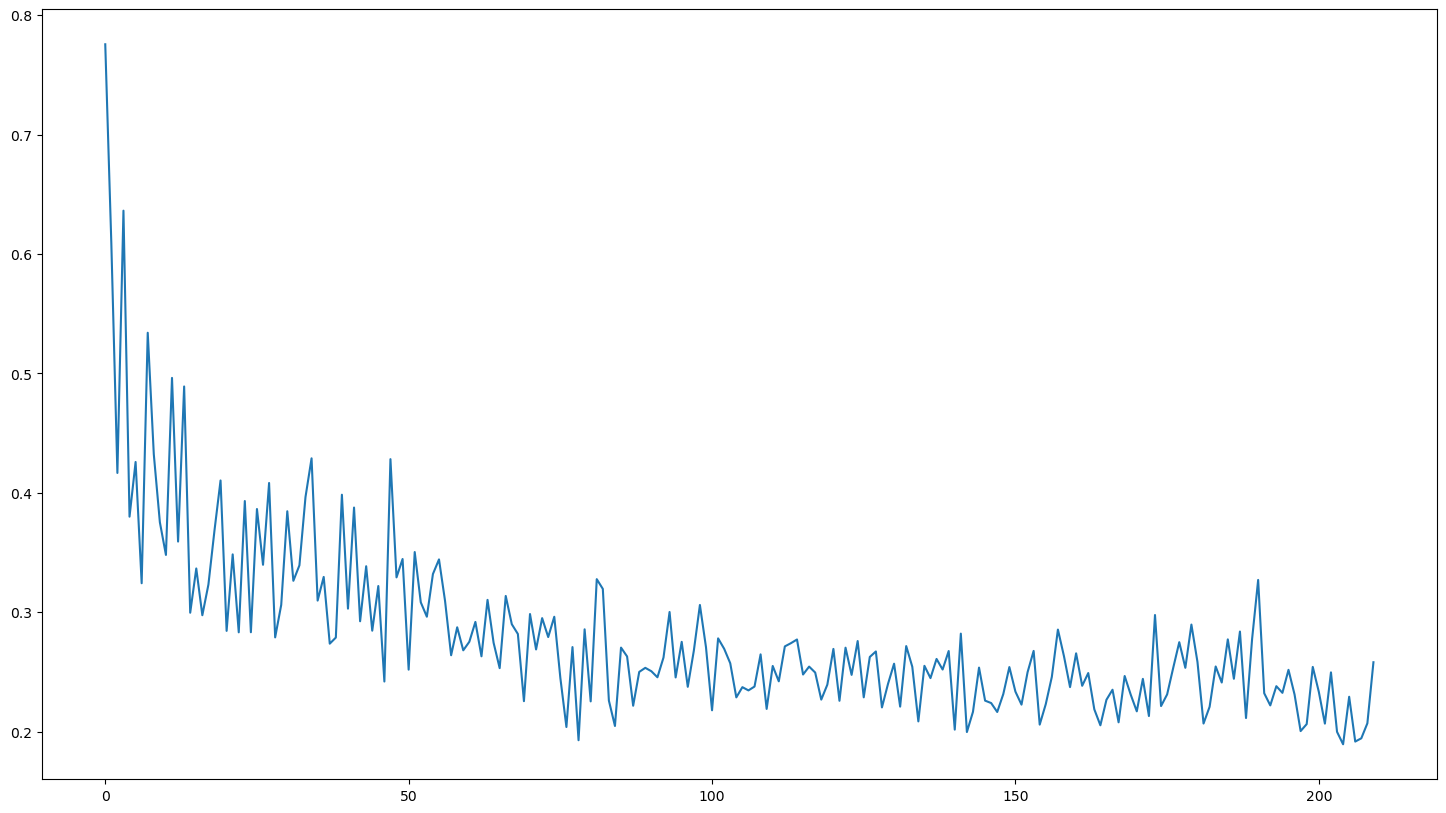

In [166]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic_ws_online_MI_ft['Gen_D_KL_Layer_0']))
# ax.plot(np.array(Analytic_ws_online_MI['Recog_D_KL_Layer_0']))
plt.show()

In [167]:
Analytic_ws_online_MI_ft.to_csv('Analytic_ws_online_MI_ft.csv', index = False)

In [168]:
parameters = {'Phi': Phi, 'Theta': Theta}

In [169]:
np.save('Parameters_ws_online_MI_ft',parameters)

In [170]:
wake_ft = {}
sleep_ft = {}
wake_ct = {}
sleep_ct = {}
wake_ct['Layer 0: dist'] = data_dist
wake_ct['Layer 0: H_Y'] = entropy(data_dist)
wake_ft['Layer 0: dist'] = data_dist_ft
wake_ft['Layer 0: H_Y'] = entropy_bernoulli(data_dist_ft)
dist_ct_pre_s = torch.ones(1,device=dev)
dist_ct_pre_w = data_dist
for i in range(n_layer-1):
    prob_ft_s, prob_ct_s = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
    sleep_ct['Layer '+str(n_layer-2-i)+': dist'], sleep_ct['Layer '+str(n_layer-2-i)+': H_Y'], \
    sleep_ct['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ct(dist_ct_pre_s, prob_ct_s)
    
    sleep_ft['Layer '+str(n_layer-2-i)+': dist'], sleep_ft['Layer '+str(n_layer-2-i)+': H_Y'], \
    sleep_ft['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ft(dist_ct_pre_s, prob_ft_s)
    dist_ct_pre_s = sleep_ct['Layer '+str(n_layer-2-i)+': dist']
    
    if i < n_layer-2:
        prob_ft_w, prob_ct_w = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
        wake_ct['Layer '+str(i+1)+': dist'], wake_ct['Layer '+str(i+1)+': H_Y'], \
        wake_ct['Layer '+str(i+1)+': H_YX'] = prob_matrix_ct(dist_ct_pre_w, prob_ct_w)

        wake_ft['Layer '+str(i+1)+': dist'], wake_ft['Layer '+str(i+1)+': H_Y'], \
        wake_ft['Layer '+str(i+1)+': H_YX'] = prob_matrix_ft(dist_ct_pre_w, prob_ft_w)
        dist_ct_pre_w = wake_ct['Layer '+str(i+1)+': dist']

Layer 0 Data_dist D_KL: 7.0327 H(Y): 6.8079
Layer 0 Gen_dist D_KL: 0.2189 H(Y): 6.8663
Layer 1 Recognition Distribution D_KL: 0.1553 H(Y): 5.6983 H(Y|X): 1.1761 I_XY: 4.5222
Layer 1 Generative  Distribution D_KL: 0.1014 H(Y): 6.8663 H(Y|X): 2.2658 I_XY: 4.6005
Layer 2 Recognition Distribution D_KL: 0.0474 H(Y): 4.9293 H(Y|X): 1.6385 I_XY: 3.2908
Layer 2 Generative  Distribution D_KL: 0.0448 H(Y): 5.8365 H(Y|X): 2.5583 I_XY: 3.2782
Layer 3 Recognition Distribution D_KL: 0.0421 H(Y): 3.474 H(Y|X): 1.4556 I_XY: 2.0185
Layer 3 Generative  Distribution D_KL: 0.0357 H(Y): 4.9427 H(Y|X): 2.9057 I_XY: 2.0369
Layer 4 Recognition Distribution D_KL: 0.0235 H(Y): 1.9526 H(Y|X): 0.8969 I_XY: 1.0557
Layer 4 Generative  Distribution D_KL: 0.0224 H(Y): 3.5657 H(Y|X): 2.4879 I_XY: 1.0779
Layer 4 Generative  Distribution D_KL: 0.0224 H(Y): 1.9956 H(Y|X): 1.9956 I_XY: 0.0


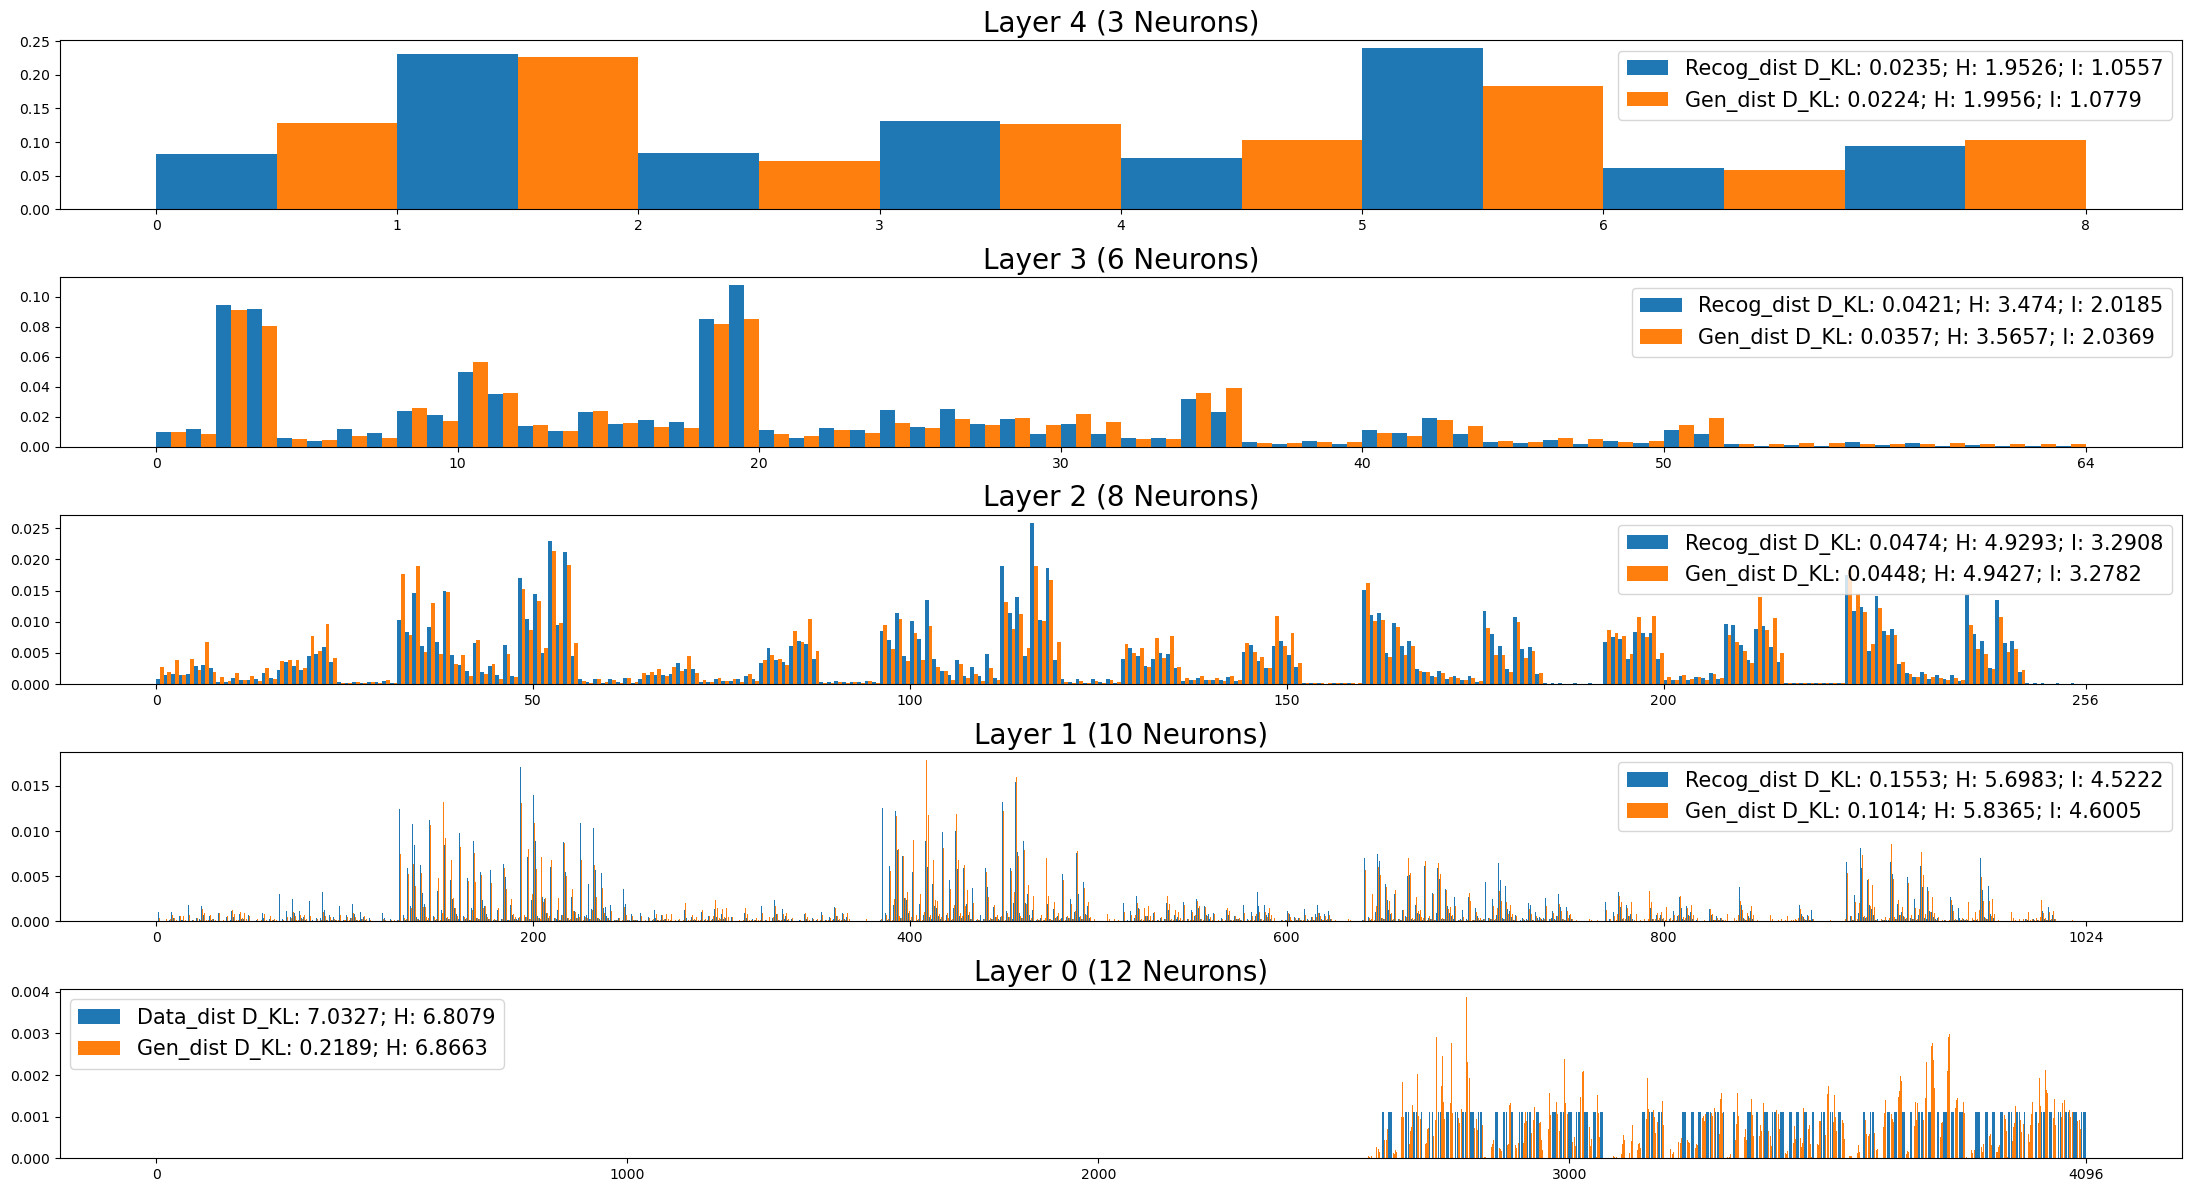

In [171]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(22, 12))
# fig_ct.suptitle("Layer-wise Categorical Distribution",fontsize=25)

for i in range(n_layer-1):
    dist_w = wake_ct['Layer '+str(i)+': dist']
    dist_s = sleep_ct['Layer '+str(i)+': dist']
    
    if i > 0:
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        H_YX_w = wake_ct['Layer '+str(i)+': H_YX'].item()
        I_w = H_Y_w - H_YX_w
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_w,4)), "H(Y|X): "+str(np.around(H_YX_w,4)),"I_XY: "+str(np.around(I_w,4)))
    
        H_Y_s = sleep_ct['Layer '+str(i-1)+': H_Y'].item()
        H_YX_s = sleep_ct['Layer '+str(i-1)+': H_YX'].item()
        I_s = H_Y_s - H_YX_s
        D_KL_s = KL_divergence(dist_w,dist_s).item()
        
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_w,4))+ "; I: "+ str(np.around(I_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(sleep_ct['Layer '+str(i)+': H_Y'].item(),4))+ "; I: "+ str(np.around(I_s,4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
    
    else:
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Data_dist D_KL: "+str(np.around(D_KL_w,4)),"H(Y): "+str(np.around(H_Y_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+str(np.around(H_Y_w,4)))
        
        D_KL_s = KL_divergence(dist_w,dist_s).item()
        H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Gen_dist D_KL: "+str(np.around(D_KL_s,4)),"H(Y): "+str(np.around(H_Y_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+str(np.around(H_Y_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" ("+ str(n_dz[i].item())+" Neurons)",fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)
    
    x_lim = 2**(n_dz[n_layer-2-i])
    if i==0:
        xtick = np.arange(0,x_lim)
    elif i==1:
        xtick = np.arange(0,x_lim,10)
    elif i==2:
        xtick = np.arange(0,x_lim,50)
    elif i==3:
        xtick = np.arange(0,x_lim,200)
    elif i==4:
        xtick = np.arange(0,x_lim,1000)    
    xtick[-1] = x_lim
    ax_ct[i].set(xticks=xtick)
    
H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
H_YX_s = sleep_ct['Layer '+str(i)+': H_YX'].item()
I_s = H_Y_s - H_YX_s
D_KL_s = KL_divergence(dist_w,dist_s).item()
print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
  "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
plt.tight_layout(pad=1)    
plt.show()

Layer 0 Ground Truth D_KL: 8.7078 H(Y): 6.8079
Layer 0 Generative D_KL: 0.2295 H(Y): 6.9126
Layer 1 Recognition Distribution D_KL: 0.1579 H(Y): 5.8468 H(Y|X): 1.3116 I_XY: 4.5351
Layer 1 Generative  Distribution D_KL: 0.1188 H(Y): 6.9126 H(Y|X): 2.3602 I_XY: 4.5524
Layer 2 Recognition Distribution D_KL: 0.0778 H(Y): 4.9701 H(Y|X): 1.9465 I_XY: 3.0235
Layer 2 Generative  Distribution D_KL: 0.0753 H(Y): 5.9543 H(Y|X): 2.9371 I_XY: 3.0172
Layer 3 Recognition Distribution D_KL: 0.0488 H(Y): 3.5471 H(Y|X): 1.3967 I_XY: 2.1504
Layer 3 Generative  Distribution D_KL: 0.0511 H(Y): 4.9557 H(Y|X): 2.7703 I_XY: 2.1854
Layer 4 Recognition Distribution D_KL: 0.0146 H(Y): 1.987 H(Y|X): 0.8047 I_XY: 1.1823
Layer 4 Generative  Distribution D_KL: 0.0151 H(Y): 3.5614 H(Y|X): 2.3991 I_XY: 1.1622
Layer 4 Generative  Distribution D_KL: 0.0151 H(Y): 1.9678 H(Y|X): 1.9678 I_XY: 0.0


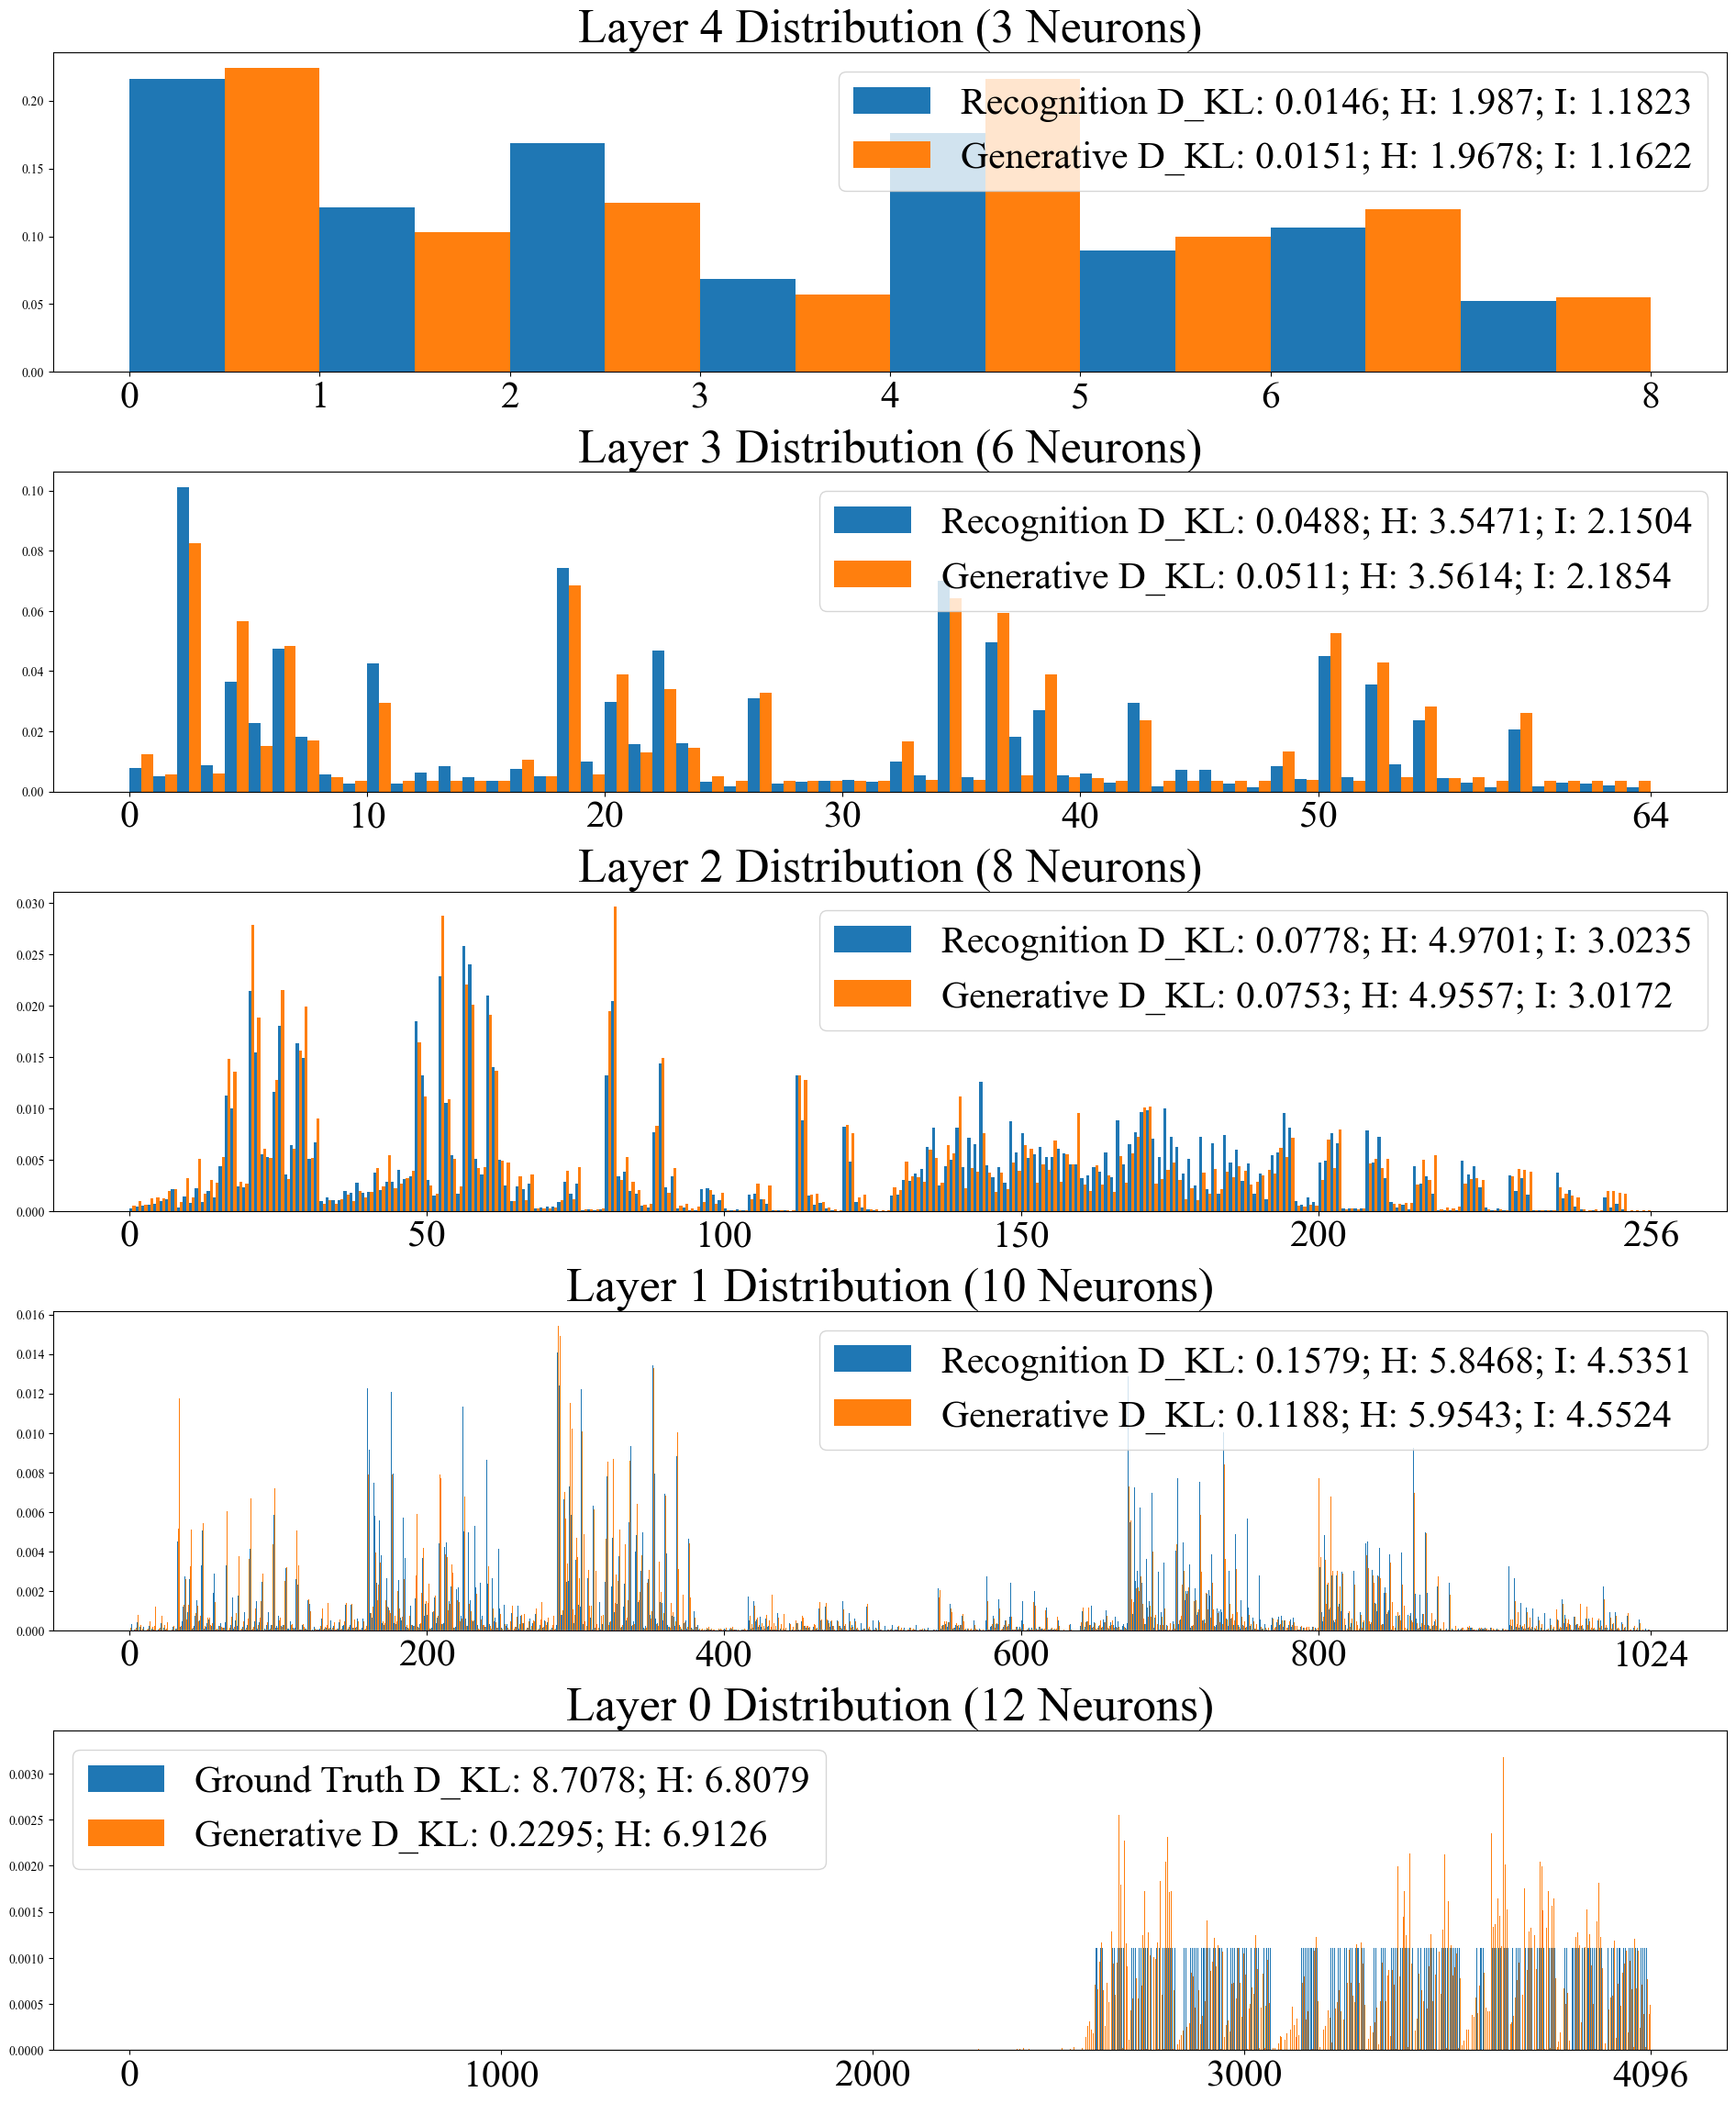

In [218]:
csfont = {'fontname':'Times New Roman'}
matplotlib.rcParams['font.family'] = 'Times New Roman'
plt.rc('xtick', labelsize=30)
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(19, 23))
# fig_ct.suptitle("Layer-wise Categorical Distribution",fontsize=25)

for i in range(n_layer-1):
    dist_w = wake_ct['Layer '+str(i)+': dist']
    dist_s = sleep_ct['Layer '+str(i)+': dist']
    
    if i > 0:
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        H_YX_w = wake_ct['Layer '+str(i)+': H_YX'].item()
        I_w = H_Y_w - H_YX_w
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_w,4)), "H(Y|X): "+str(np.around(H_YX_w,4)),"I_XY: "+str(np.around(I_w,4)))
    
        H_Y_s = sleep_ct['Layer '+str(i-1)+': H_Y'].item()
        H_YX_s = sleep_ct['Layer '+str(i-1)+': H_YX'].item()
        I_s = H_Y_s - H_YX_s
        D_KL_s = KL_divergence(dist_w,dist_s).item()
        
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recognition D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_w,4))+ "; I: "+ str(np.around(I_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Generative D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(sleep_ct['Layer '+str(i)+': H_Y'].item(),4))+ "; I: "+ str(np.around(I_s,4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
    
    else:
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Ground Truth D_KL: "+str(np.around(D_KL_w,4)),"H(Y): "+str(np.around(H_Y_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Ground Truth D_KL: " + str(np.around(D_KL_w,4))+"; H: "+str(np.around(H_Y_w,4)))
        
        D_KL_s = KL_divergence(dist_w,dist_s).item()
        H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Generative D_KL: "+str(np.around(D_KL_s,4)),"H(Y): "+str(np.around(H_Y_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Generative D_KL: " + str(np.around(D_KL_s,4))+"; H: "+str(np.around(H_Y_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" Distribution ("+ str(n_dz[i].item())+" Neurons)",fontsize=37)
    ax_ct[n_layer-2-i].legend(fontsize=30)
    
    x_lim = 2**(n_dz[n_layer-2-i])
    if i==0:
        xtick = np.arange(0,x_lim)
    elif i==1:
        xtick = np.arange(0,x_lim,10)
    elif i==2:
        xtick = np.arange(0,x_lim,50)
    elif i==3:
        xtick = np.arange(0,x_lim,200)
    elif i==4:
        xtick = np.arange(0,x_lim,1000)    
    xtick[-1] = x_lim
    ax_ct[i].set(xticks=xtick)
    
H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
H_YX_s = sleep_ct['Layer '+str(i)+': H_YX'].item()
I_s = H_Y_s - H_YX_s
D_KL_s = KL_divergence(dist_w,dist_s).item()
print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
  "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))    
plt.tight_layout(pad=1)    
plt.show()

Layer 0 Data_dist D_KL: 0.0799 H(Y): 7.3327
Layer 0 Gen_dist D_KL: 0.0782 H(Y): 7.3857
Layer 1 Recognition Distribution D_KL: 0.0694 H(Y): 6.0342 H(Y|X): 0.138 I_XY: 5.8961
Layer 1 Generative  Distribution D_KL: 0.065 H(Y): 7.3857 H(Y|X): 1.2639 I_XY: 6.1218
Layer 2 Recognition Distribution D_KL: 0.0502 H(Y): 5.3581 H(Y|X): 0.4002 I_XY: 4.9579
Layer 2 Generative  Distribution D_KL: 0.0507 H(Y): 6.0782 H(Y|X): 1.2359 I_XY: 4.8422
Layer 3 Recognition Distribution D_KL: 0.0235 H(Y): 3.8834 H(Y|X): 0.4004 I_XY: 3.483
Layer 3 Generative  Distribution D_KL: 0.0239 H(Y): 5.2863 H(Y|X): 2.2175 I_XY: 3.0688
Layer 4 Recognition Distribution D_KL: 0.0041 H(Y): 1.4176 H(Y|X): 0.2377 I_XY: 1.1799
Layer 4 Generative  Distribution D_KL: 0.0045 H(Y): 3.8467 H(Y|X): 2.9969 I_XY: 0.8498


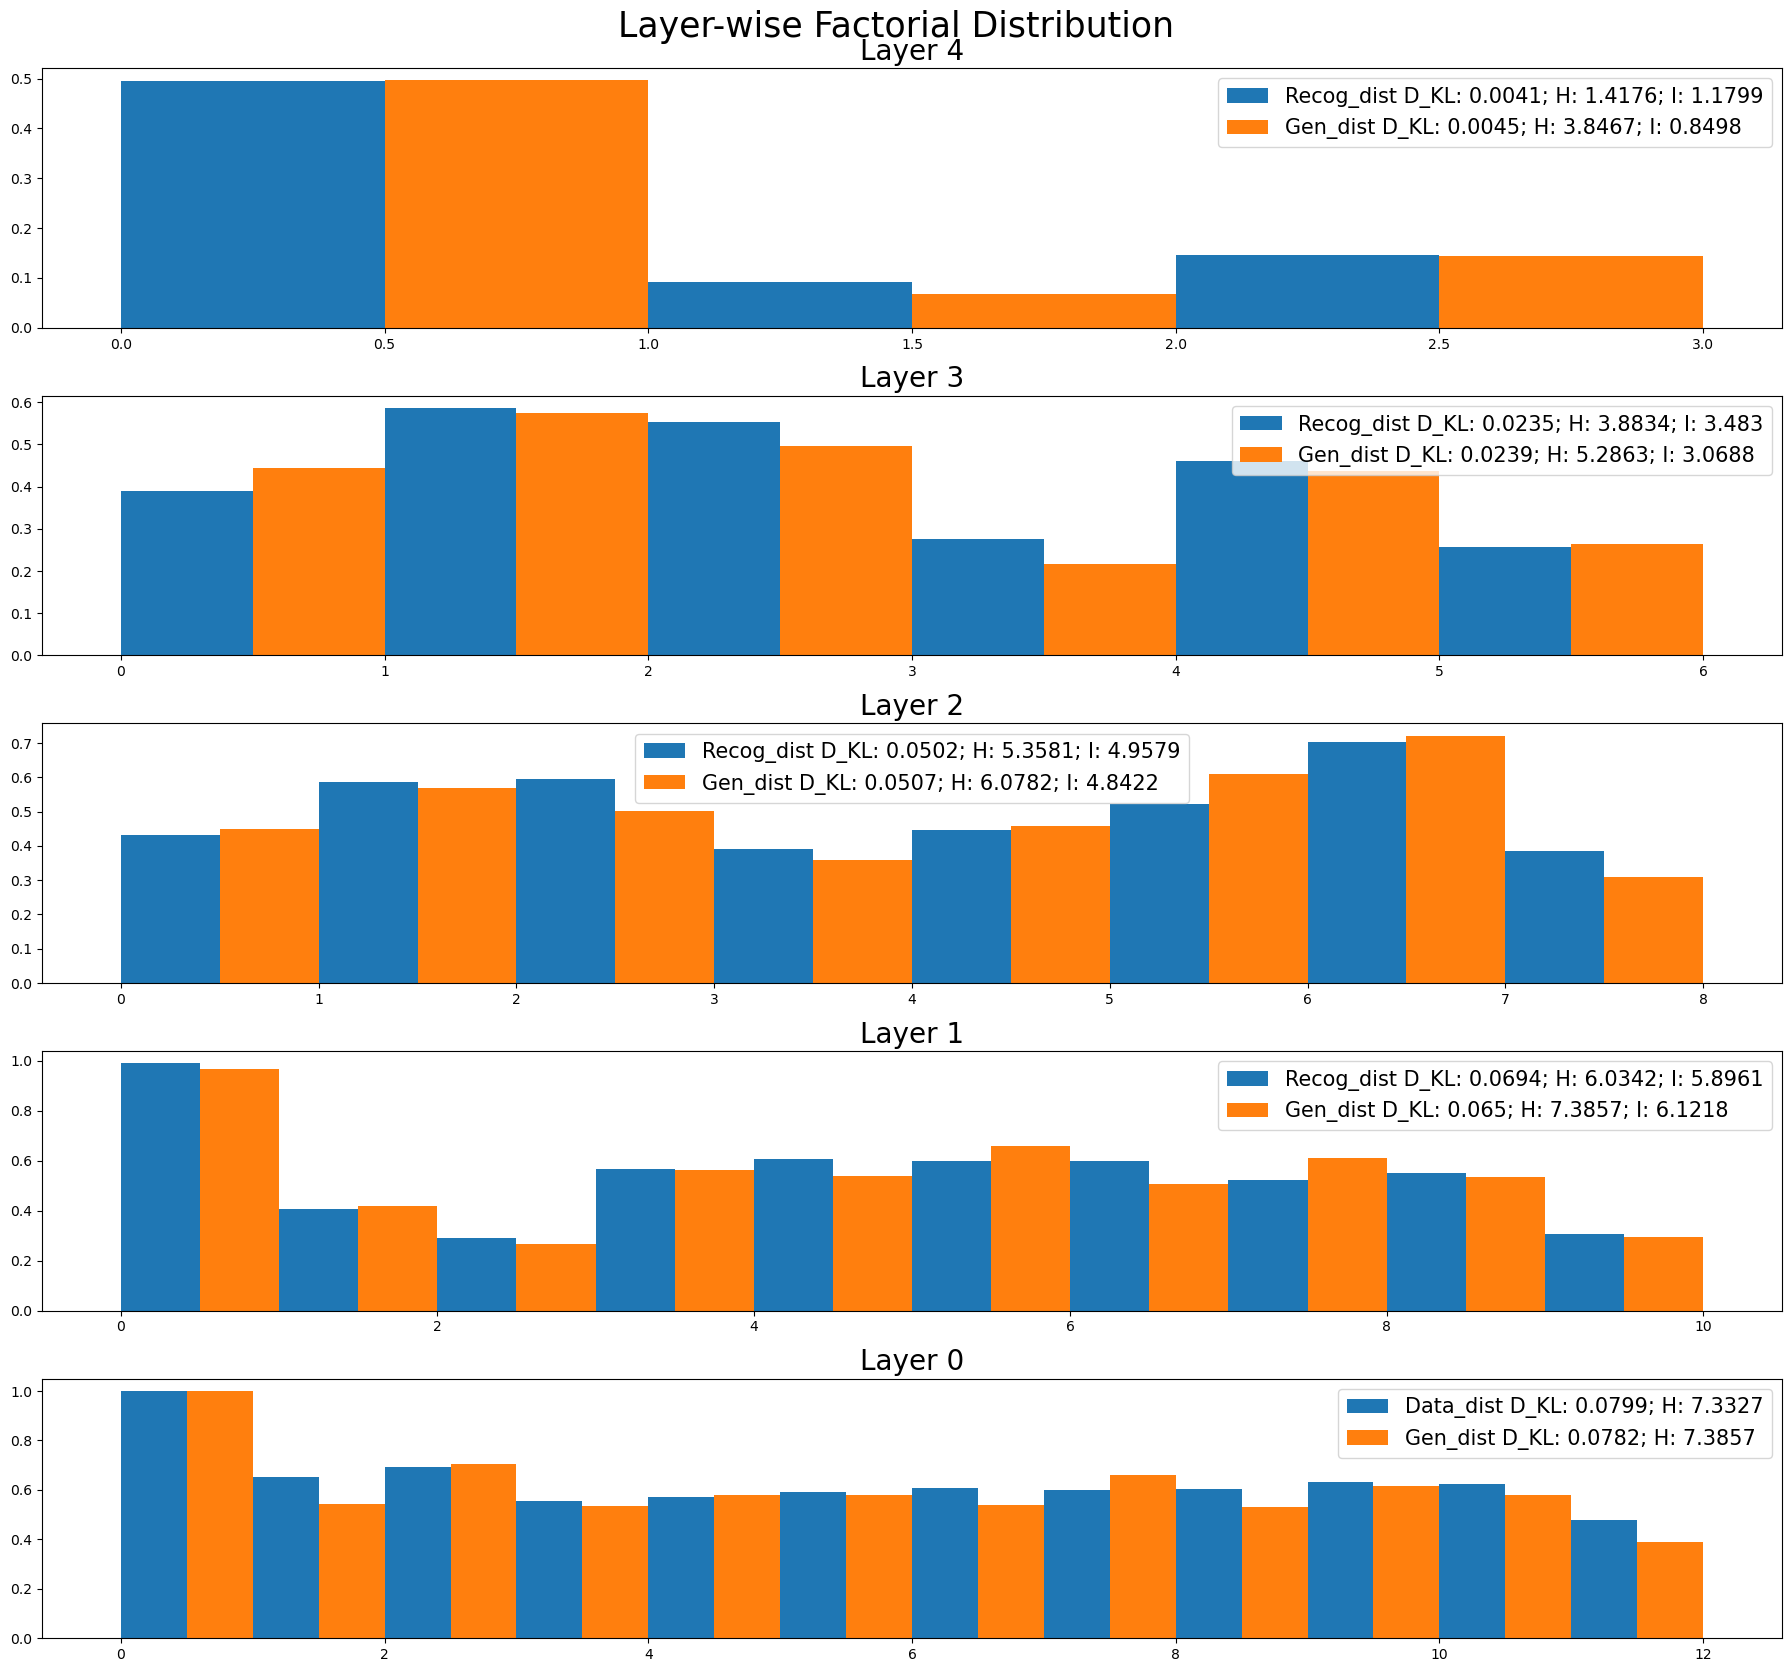

In [217]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(18, 17))
fig_ct.suptitle("Layer-wise Factorial Distribution",fontsize=25)
for i in range(n_layer-1):
    dist_s = sleep_ft['Layer '+str(i)+': dist']
    dist_w = wake_ft['Layer '+str(i)+': dist']
    
    if i > 0:
        H_Y_w = wake_ft['Layer '+str(i)+': H_Y'].item()
        H_YX_w = wake_ft['Layer '+str(i)+': H_YX'].item()
        I_w = H_Y_w - H_YX_w
        D_KL_w = KL_divergence_bernoulli(dist_s,dist_w).item()
        
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_w,4)), "H(Y|X): "+str(np.around(H_YX_w,4)),"I_XY: "+str(np.around(I_w,4)))
           
        H_Y_s = sleep_ft['Layer '+str(i-1)+': H_Y'].item()
        H_YX_s = sleep_ft['Layer '+str(i-1)+': H_YX'].item()
        I_s = H_Y_s - H_YX_s
        D_KL_s = KL_divergence_bernoulli(dist_w,dist_s).item()
        
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_w,4))+ "; I: "+ str(np.around(I_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(H_Y_s,4))+ "; I: "+ str(np.around(I_s,4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
    
    else:
        D_KL_w = KL_divergence_bernoulli(dist_s,dist_w).item()
        H_Y_w = wake_ft['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Data_dist D_KL: "+str(np.around(D_KL_w,4)),"H(Y): "+str(np.around(H_Y_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+str(np.around(H_Y_w,4)))
        
        D_KL_s = KL_divergence_bernoulli(dist_w,dist_s).item()
        H_Y_s = sleep_ft['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Gen_dist D_KL: "+str(np.around(D_KL_s,4)),"H(Y): "+str(np.around(H_Y_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+str(np.around(H_Y_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i),fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)

plt.tight_layout(pad=1)    
plt.show()

In [200]:
def causal(n_dz, Theta, cause_layer, cause_indices, dev):
    """
    Arguments:
    n_dz -- structure of the Hemholtz machine, torch tensor of shape (n_layer, )
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    cause_layer -- layer number of the cause. Integer
    cause_indices -- the indices of the causes out of 2^n_x in its layer. Torch tensor of shape (n_cause, )
    dev -- torch device
    
    Returns:
    causal_dist -- dictionary of causal ditributions, of length cause_layer.
    """
    causal_dist = {}
    prob_ft, prob_ct = one_step_prob_matrix(n_dz[cause_layer], Theta["Theta_" + str(cause_layer) + str(cause_layer-1)], dev) # (2**n_z, 2**n_{z-1})
    dist_ct_pre = prob_ct[cause_indices,:]
    causal_dist['Layer '+str(cause_layer-1)+': dist'] = dist_ct_pre
    for i in range(1,cause_layer):
        prob_ft, prob_ct = one_step_prob_matrix(n_dz[cause_layer-i], Theta["Theta_" + str(cause_layer-i) + str(cause_layer-i-1)],dev)
        causal_dist['Layer '+str(cause_layer-i-1)+': dist'], causal_dist['Layer '+str(cause_layer-i-1)+': H_Y'], \
        causal_dist['Layer '+str(cause_layer-i-1)+': H_YX'] = prob_matrix_ct(dist_ct_pre, prob_ct)
        dist_ct_pre = causal_dist['Layer '+str(cause_layer-i-1)+': dist']
    return causal_dist

In [201]:
cause_layer = 4
cause_indices = torch.arange(2**n_dz[cause_layer])
causal_dist = causal(n_dz, Theta, cause_layer, cause_indices, dev)
causal_dist

{'Layer 3: dist': tensor([[1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02],
         [3.2430e-02, 9.4375e-02, 3.9199e-06, 1.1407e-05, 4.7064e-06, 1.3696e-05,
          5.6888e-10, 

In [202]:
bnr = binarilize(cause_indices,n_dz[cause_layer],dev).to('cpu').numpy()
bnr

array([[0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 1, 1, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 1, 0, 1]], dtype=int64)

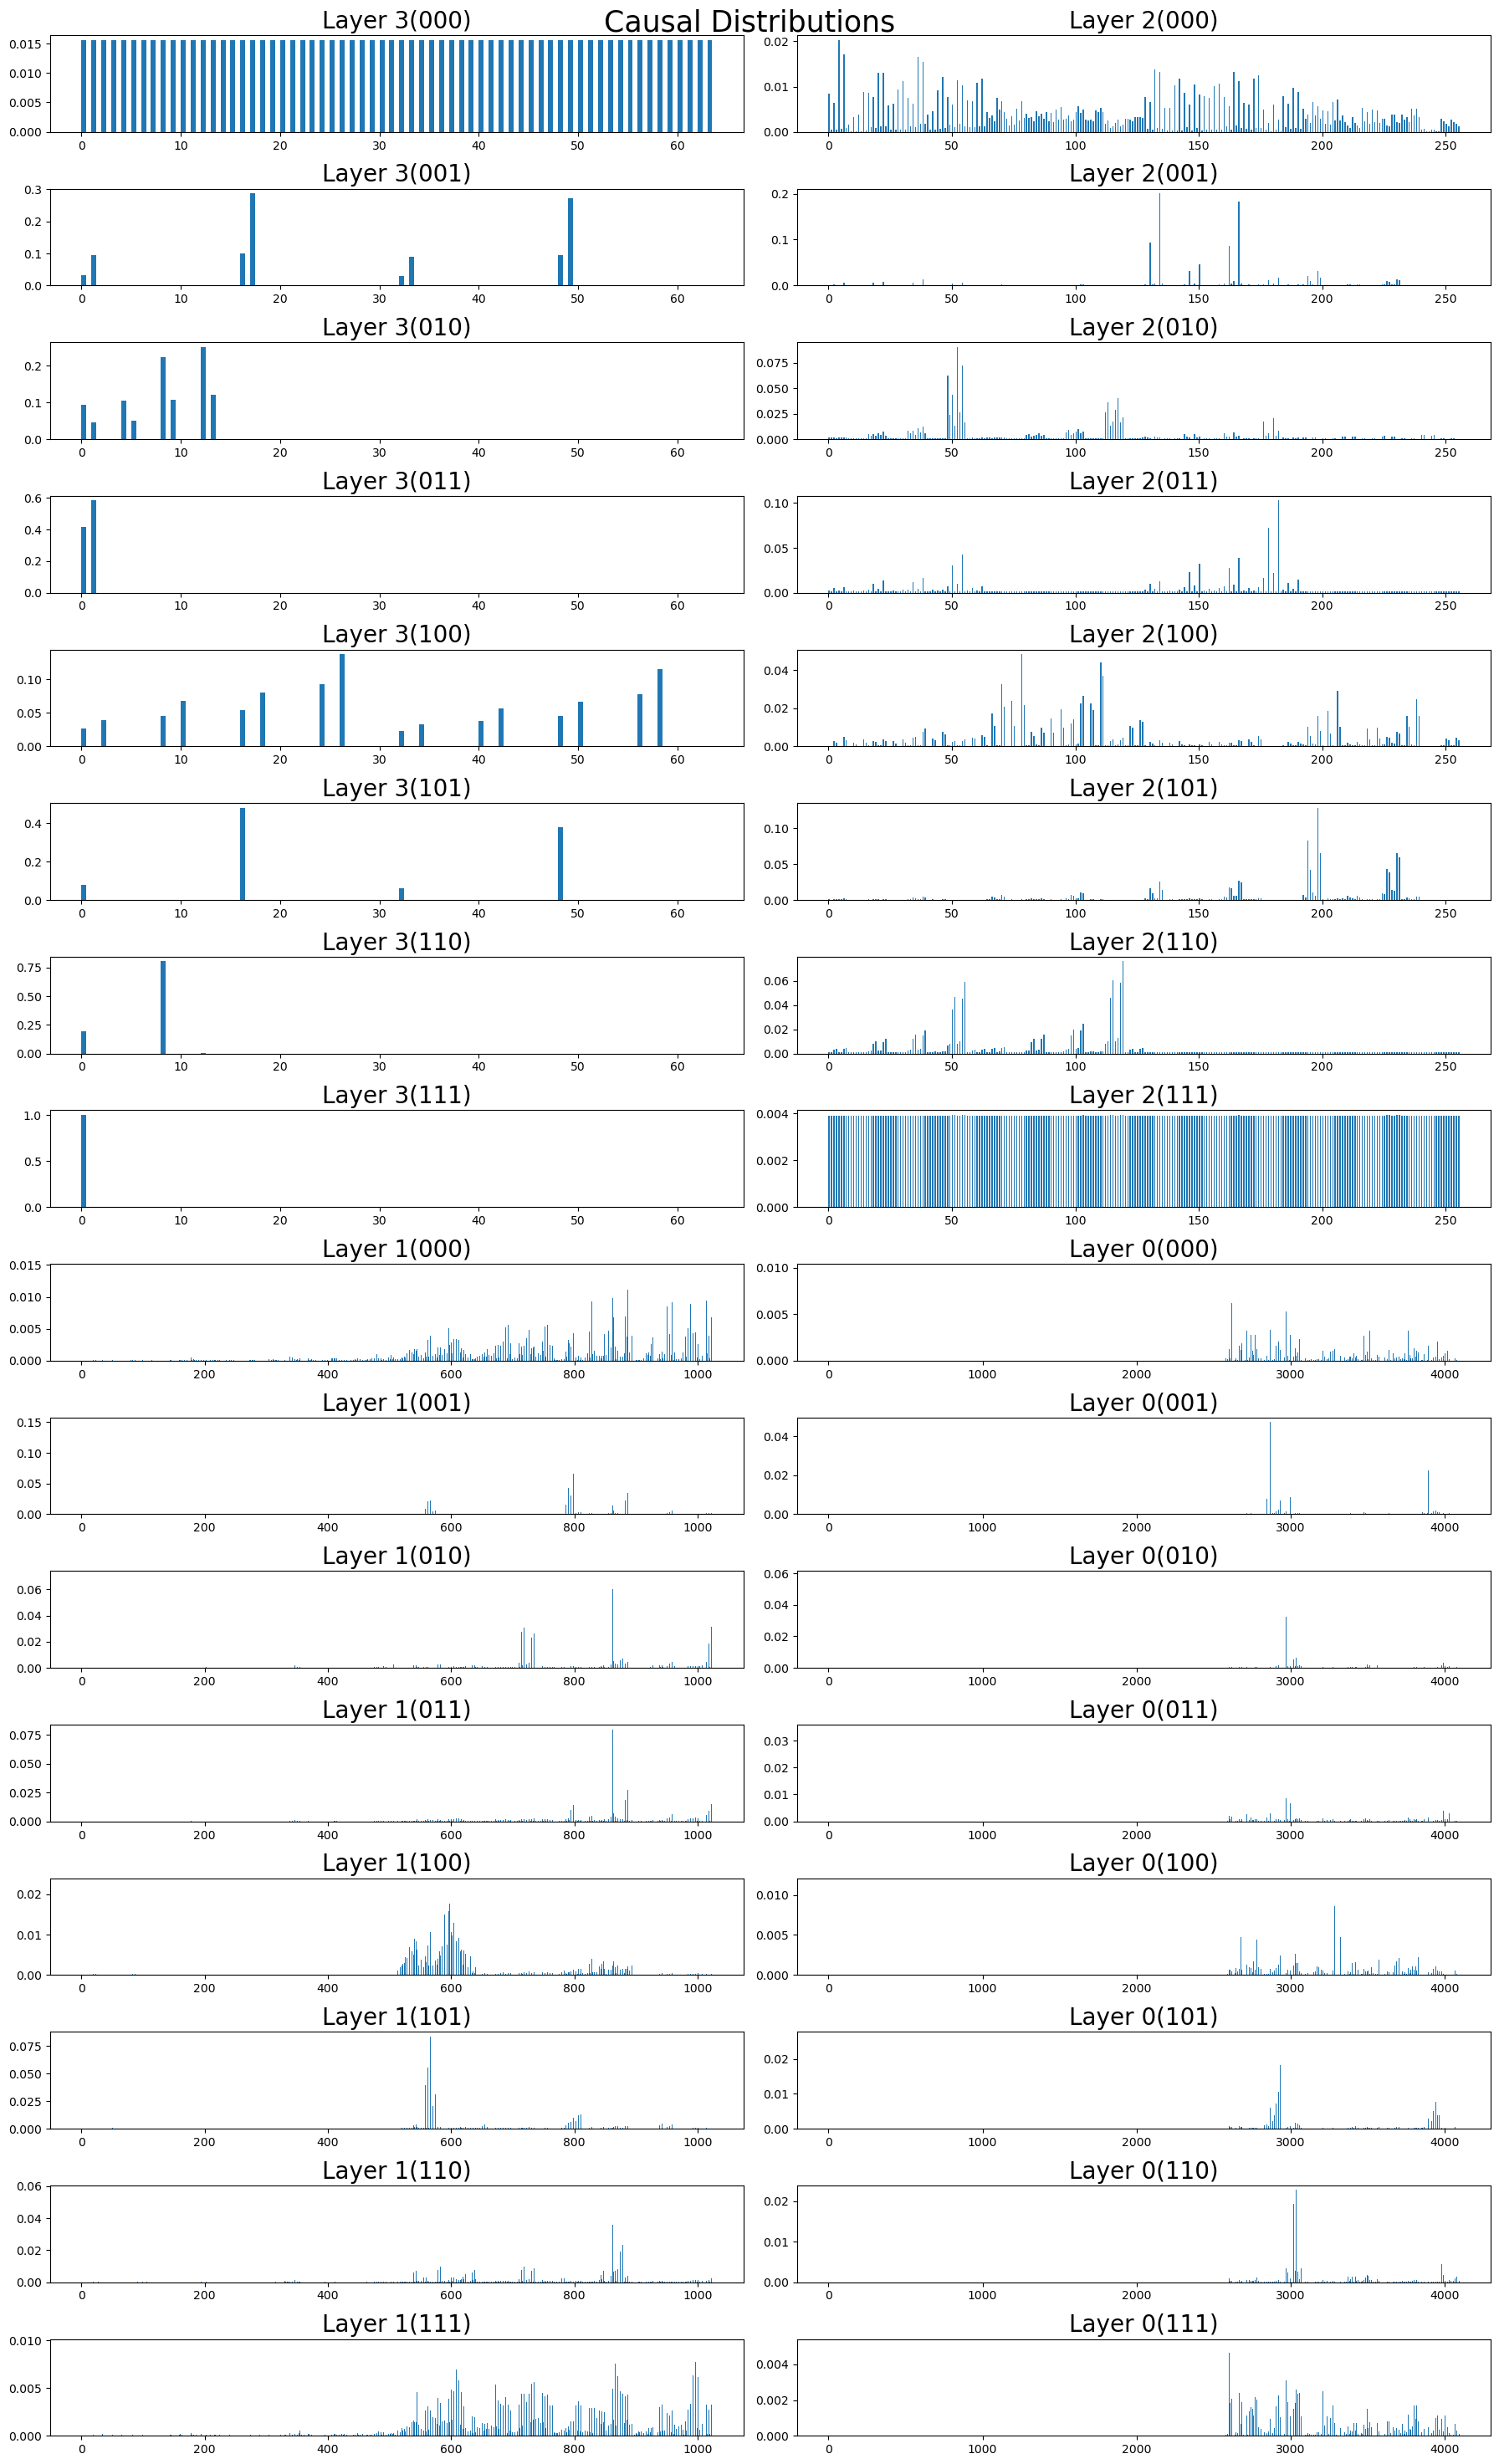

In [203]:
fig, ax = plt.subplots(cause_layer*int(len(cause_indices)/2+0.5), 2, figsize=(18, 30))
fig.suptitle("Causal Distributions",fontsize=25)
for i in range(cause_layer-1,-1,-1):
    row_ind = int((cause_layer-1-i)/2)*len(cause_indices)
    col_ind = (cause_layer-1-i)%2
    for j in range(len(cause_indices)):
        dist = causal_dist['Layer '+str(i)+': dist'][j,:]
        ax[row_ind+j, col_ind].bar(np.arange(2**n_dz[i]),dist.to('cpu').numpy(),width=0.5,align='edge',\
                               label = "Data Distribution")
        ax[row_ind+j, col_ind].set_title("Layer "+str(i)+'('+''.join(bnr[:,j].reshape(n_dz[cause_layer],).astype(str))+')',fontsize=20)
plt.tight_layout(pad=1)    
plt.show()

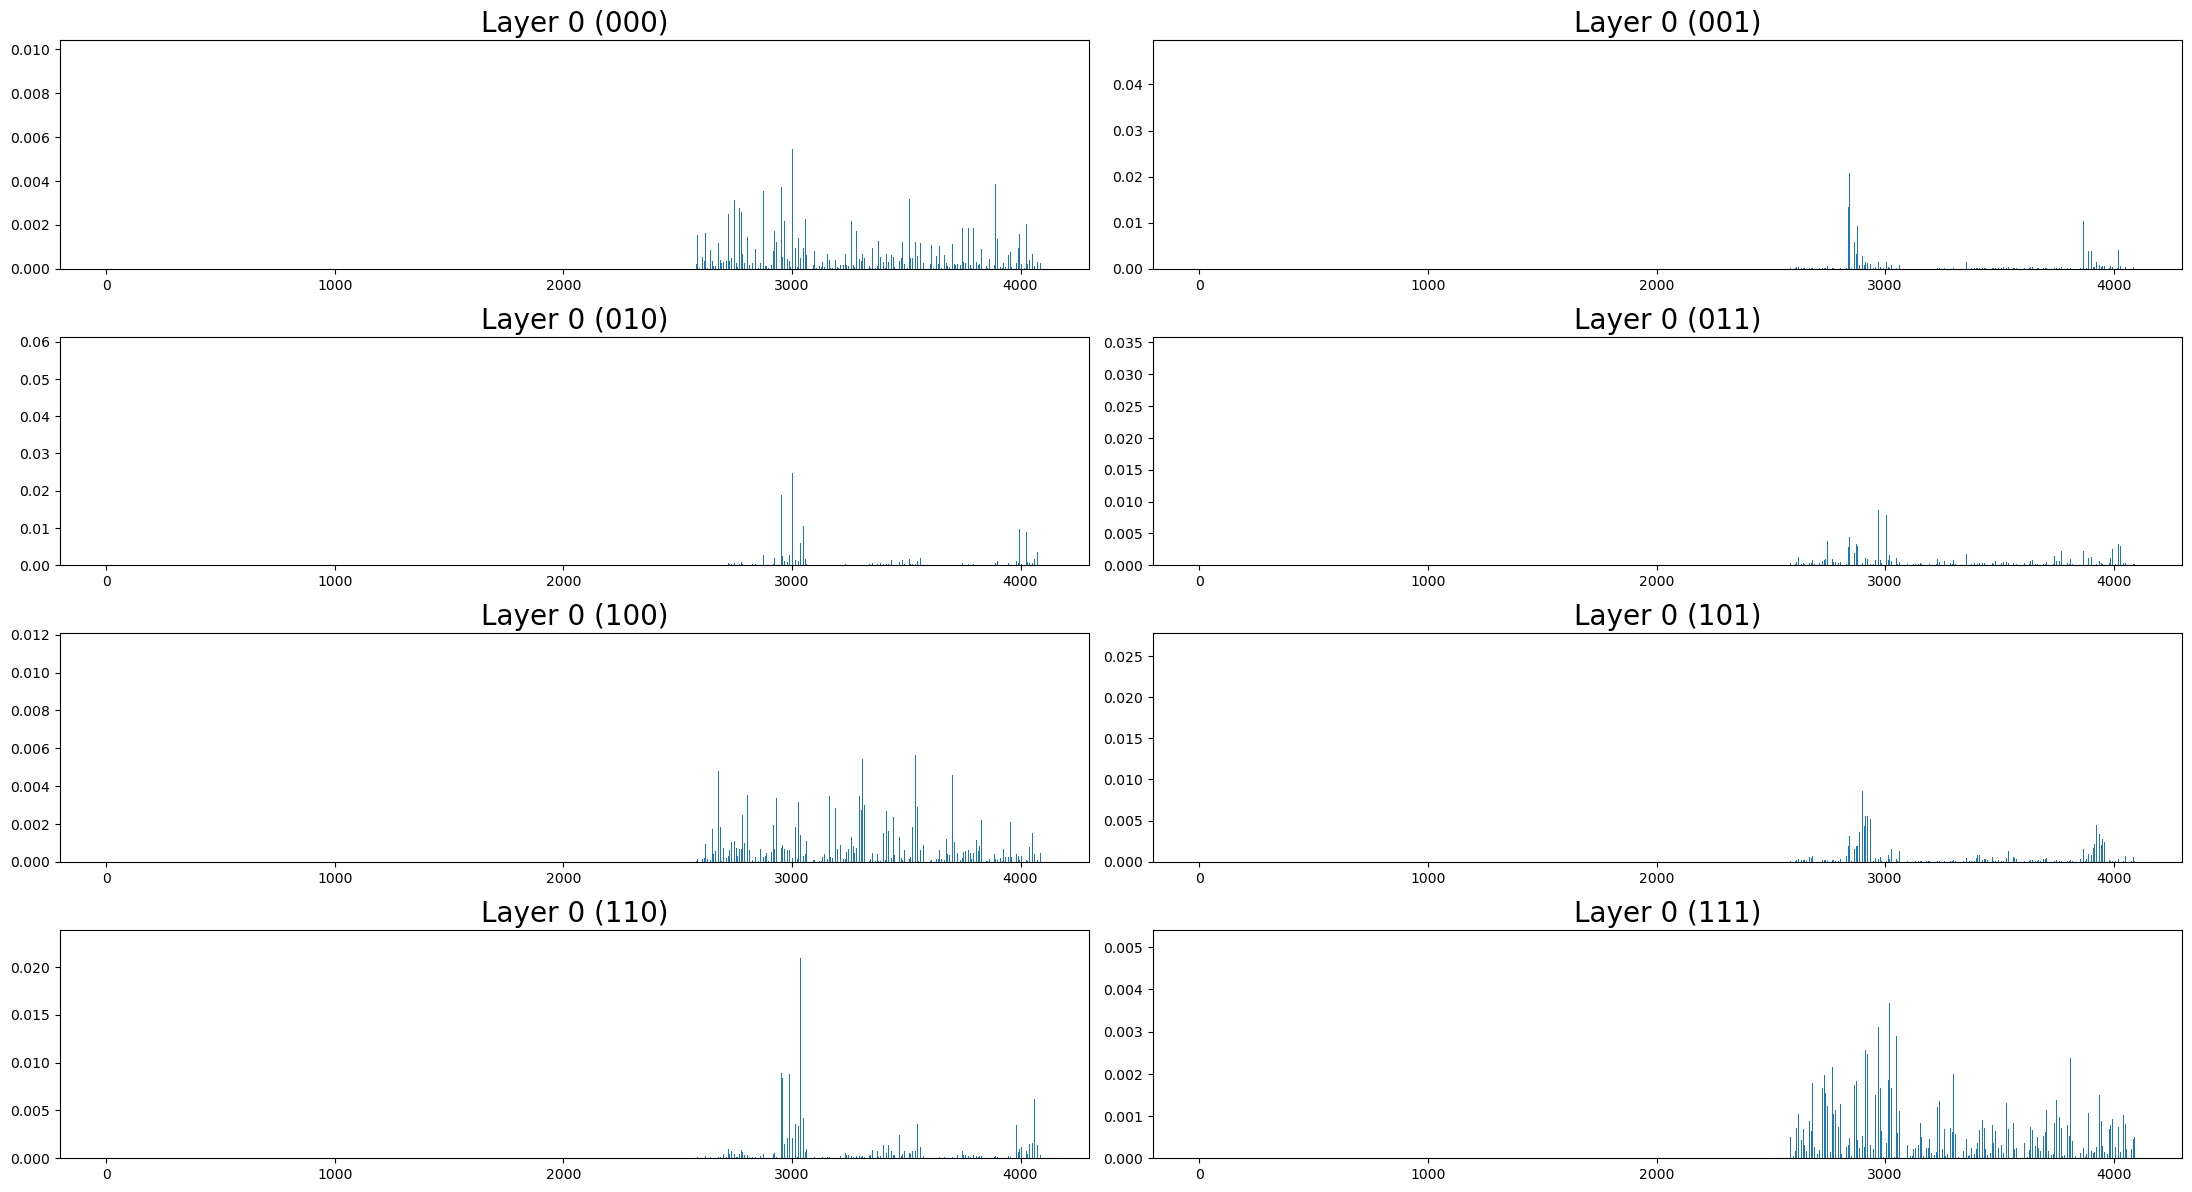

In [227]:
fig, ax = plt.subplots(int(len(cause_indices)/2+0.5), 2, figsize=(22, 12))
# fig.suptitle("Causal Distributions",fontsize=25)
i = cause_layer-4
for j in range(len(cause_indices)):
    dist = causal_dist['Layer '+str(i)+': dist'][j,:]
    row_ind = int(j/2)
    col_ind = j%2
    ax[row_ind, col_ind].bar(np.arange(2**n_dz[i]),dist.to('cpu').numpy(),width=0.5,align='edge',label = "Data Distribution")
    ax[row_ind, col_ind].set_title("Layer "+str(i)+' ('+''.join(bnr[:,j].reshape(n_dz[cause_layer],).astype(str))+')',fontsize=20)
plt.tight_layout(pad=1)    
plt.show()

In [228]:
anti_data_dist = (data_dist == 0).long()/(data_dist == 0).long().sum()
anti_data_dist

tensor([0.0003, 0.0003, 0.0003,  ..., 0.0000, 0.0000, 0.0000])

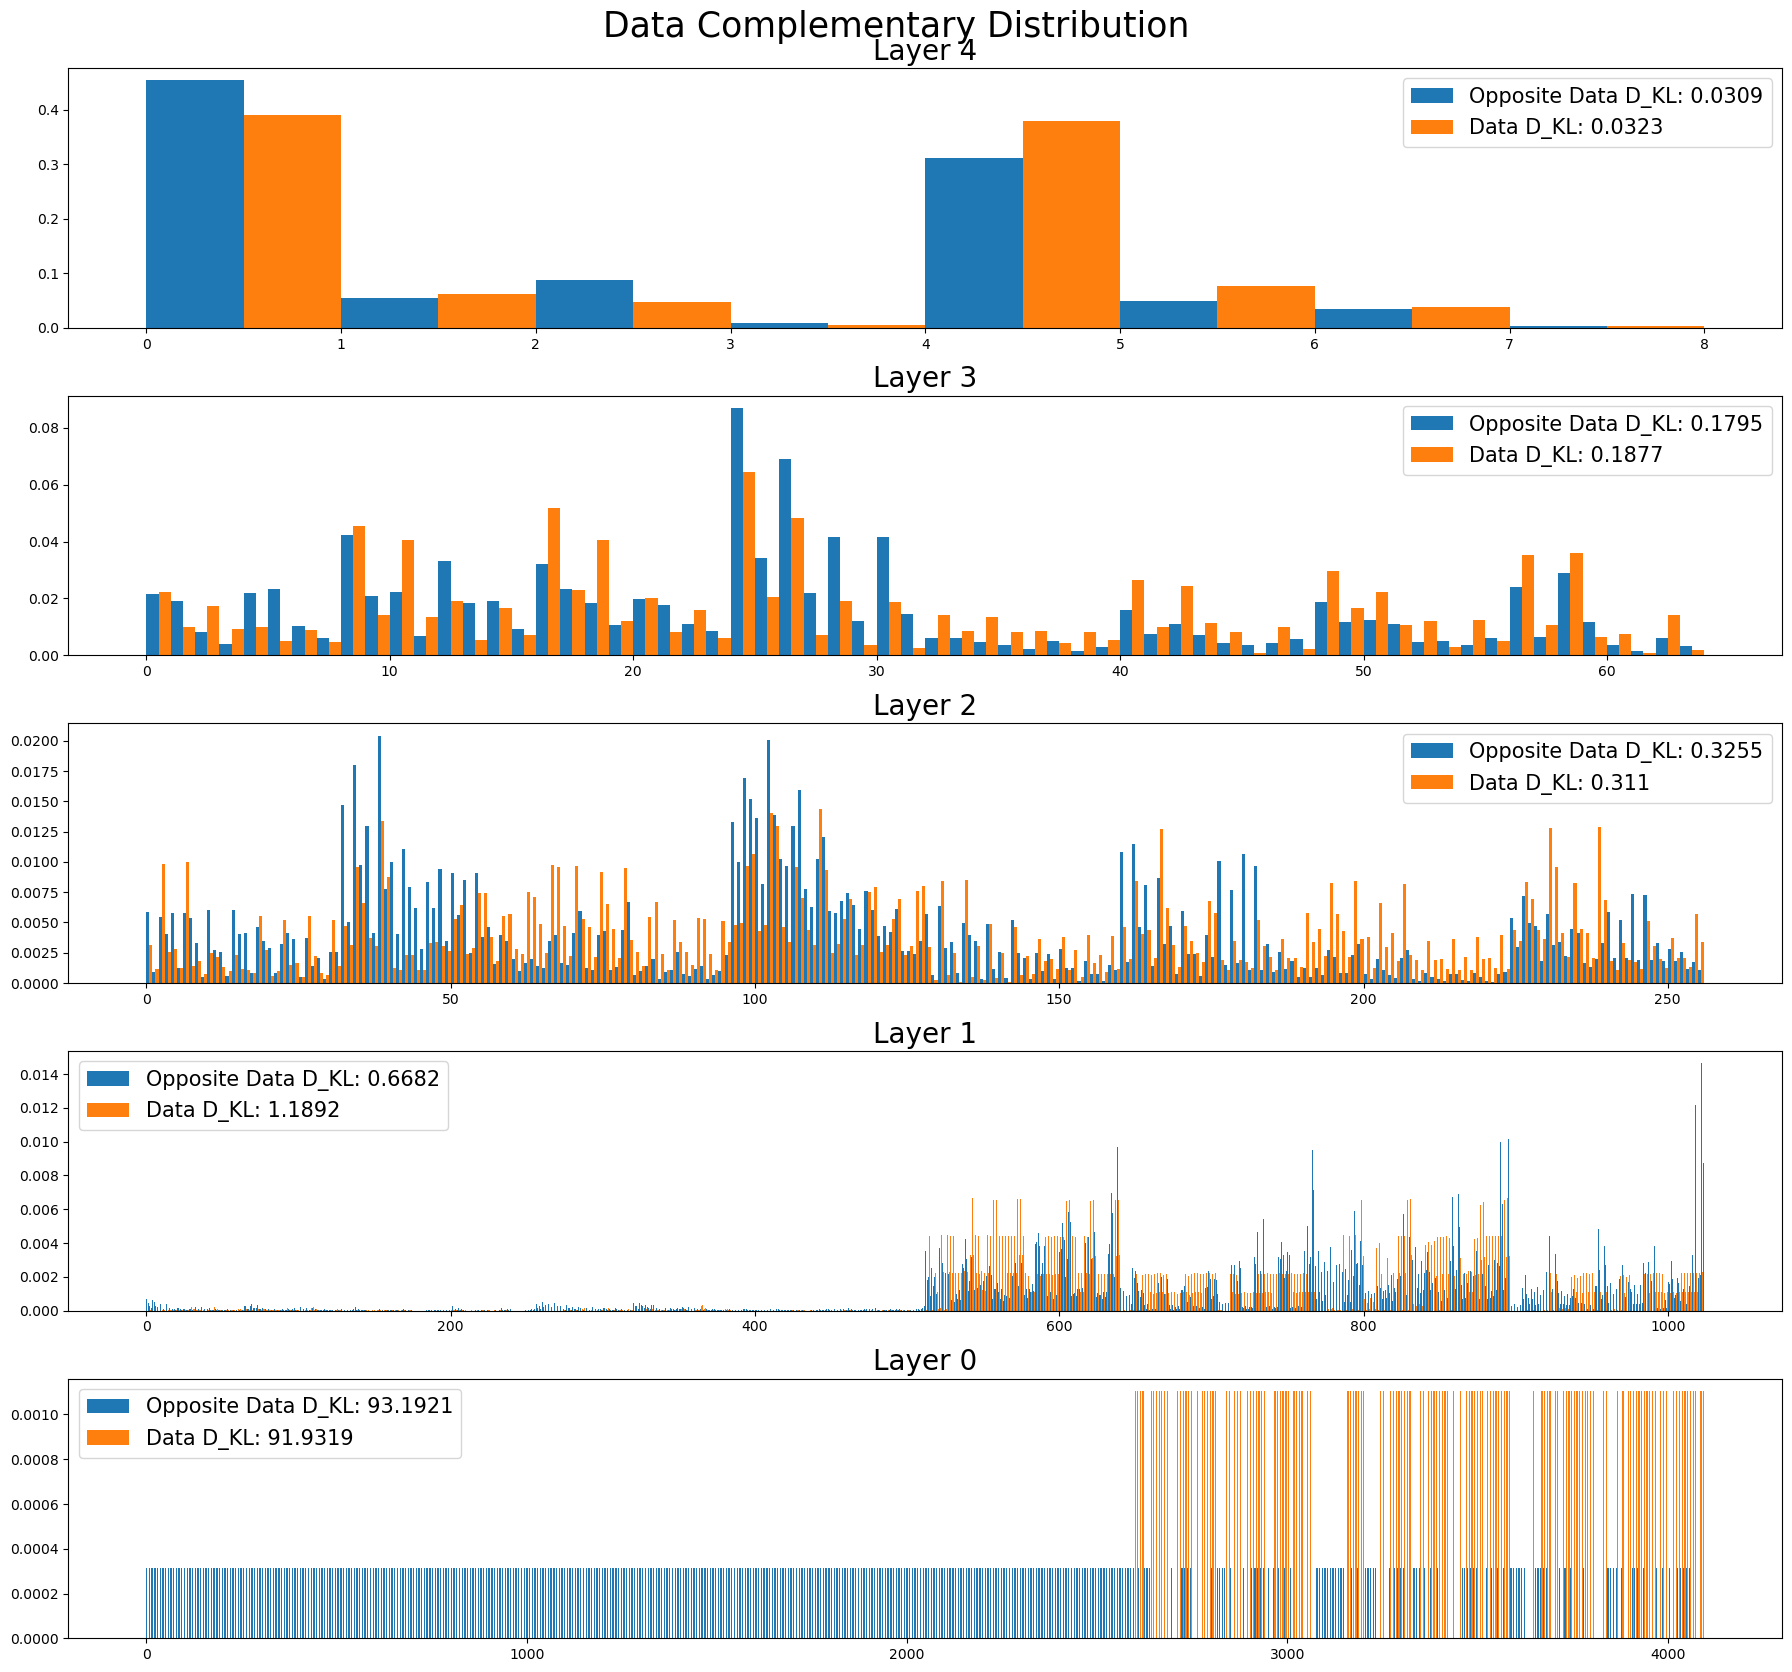

In [229]:
fig, ax = plt.subplots(n_layer-1, 1, figsize=(18, 17))
fig.suptitle("Data Complementary Distribution",fontsize=25)
dist_ct_pre = anti_data_dist
for i in range(n_layer-1):
    dist_w = wake_ct['Layer '+str(i)+': dist']
    D_KL_opp = KL_divergence(dist_w, dist_ct_pre).item()
    D_KL = KL_divergence(dist_ct_pre,dist_w).item()
    
    ax[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_ct_pre.to('cpu').numpy(),width=0.5,align='edge',\
                        label='Opposite Data D_KL: '+ str(np.around(D_KL_opp,4)))
    ax[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                        label = "Data D_KL: "+ str(np.around(D_KL,4)))
    ax[n_layer-2-i].set_title("Layer "+str(i),fontsize=20)
    ax[n_layer-2-i].legend(fontsize=15)
    
    if i < n_layer-2:
        prob_ft, prob_ct = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
        dist_ct_pre = torch.matmul(dist_ct_pre, prob_ct)
    
plt.tight_layout(pad=1)    
plt.show()

In [230]:
def pp_dist(Theta,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    dev -- torch device
    Returns:
    pp_dict -- pp distribution dictionary, of length n_layer-1
    """
    pp_dict = {}
    dist_pre = torch.ones(1,device=dev)
    for i in range(len(Theta),0,-1):
        prob_ft, prob_ct = one_step_prob_matrix(n_dz[i], Theta["Theta_" + str(i) + str(i-1)],dev)
        dist_pre = torch.matmul(dist_pre,prob_ct)
        pp_dict['Layer_'+str(i-1)] = dist_pre
    return pp_dict

In [231]:
pp_dict = pp_dist(Theta,dev)

In [232]:
def ground_truth(dataset,dev):
    """
    Arguments:
    dataset -- data, torch tensor of shape (n_d,n_data)
    dev -- torch device
    Returns:
    data_dist -- data distribution. Torch tensor of shape (2**n_d,)
    """
    data_dcm = decimalize(dataset,dev)
    values_d,counts_d = torch.unique(data_dcm,return_counts=True)
    data_dist = torch.zeros(2**dataset.shape[0],device=dev)
    data_dist[values_d]=counts_d/dataset.shape[1]
    return data_dist

In [233]:
def wake_dist_pp(Phi, data_dist, n_dz, pp_dict, dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data_dist -- data distribution with max entry as 1. Torch tensor of shape (2**n_d,)
    n_dz -- Helmholtz machine structure. Torch tensor of shape (n_layer,)
    pp_dict -- pp distribution dictionary, of length n_layer-1
    dev -- torch device
    Returns:
    
    """
    cause_dist = {}
    cause_dist_pp = {}
    dist_pre = data_dist
    cause_dist['Layer_0'] = dist_pre
    dist_pre_pp = data_dist * pp_dict['Layer_0']
    dist_pre_pp = dist_pre_pp/dist_pre_pp.sum()
    cause_dist_pp['Layer_0'] = dist_pre_pp
    for i in range(n_layer-2):
        prob_ft, prob_ct = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
        dist_pre = torch.matmul(dist_pre, prob_ct)
        cause_dist['Layer_'+str(i+1)] = dist_pre
        
        dist_pre_pp = torch.matmul(dist_pre_pp, prob_ct) * pp_dict['Layer_'+str(i+1)]
        dist_pre_pp = dist_pre_pp/dist_pre_pp.sum()
        cause_dist_pp['Layer_'+str(i+1)] = dist_pre_pp
    return cause_dist, cause_dist_pp

In [239]:
entire_set = binarilize(np.arange(2**n_d),n_d,dev)
test_dist = ground_truth(entire_set,dev)
test_dist

tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002])

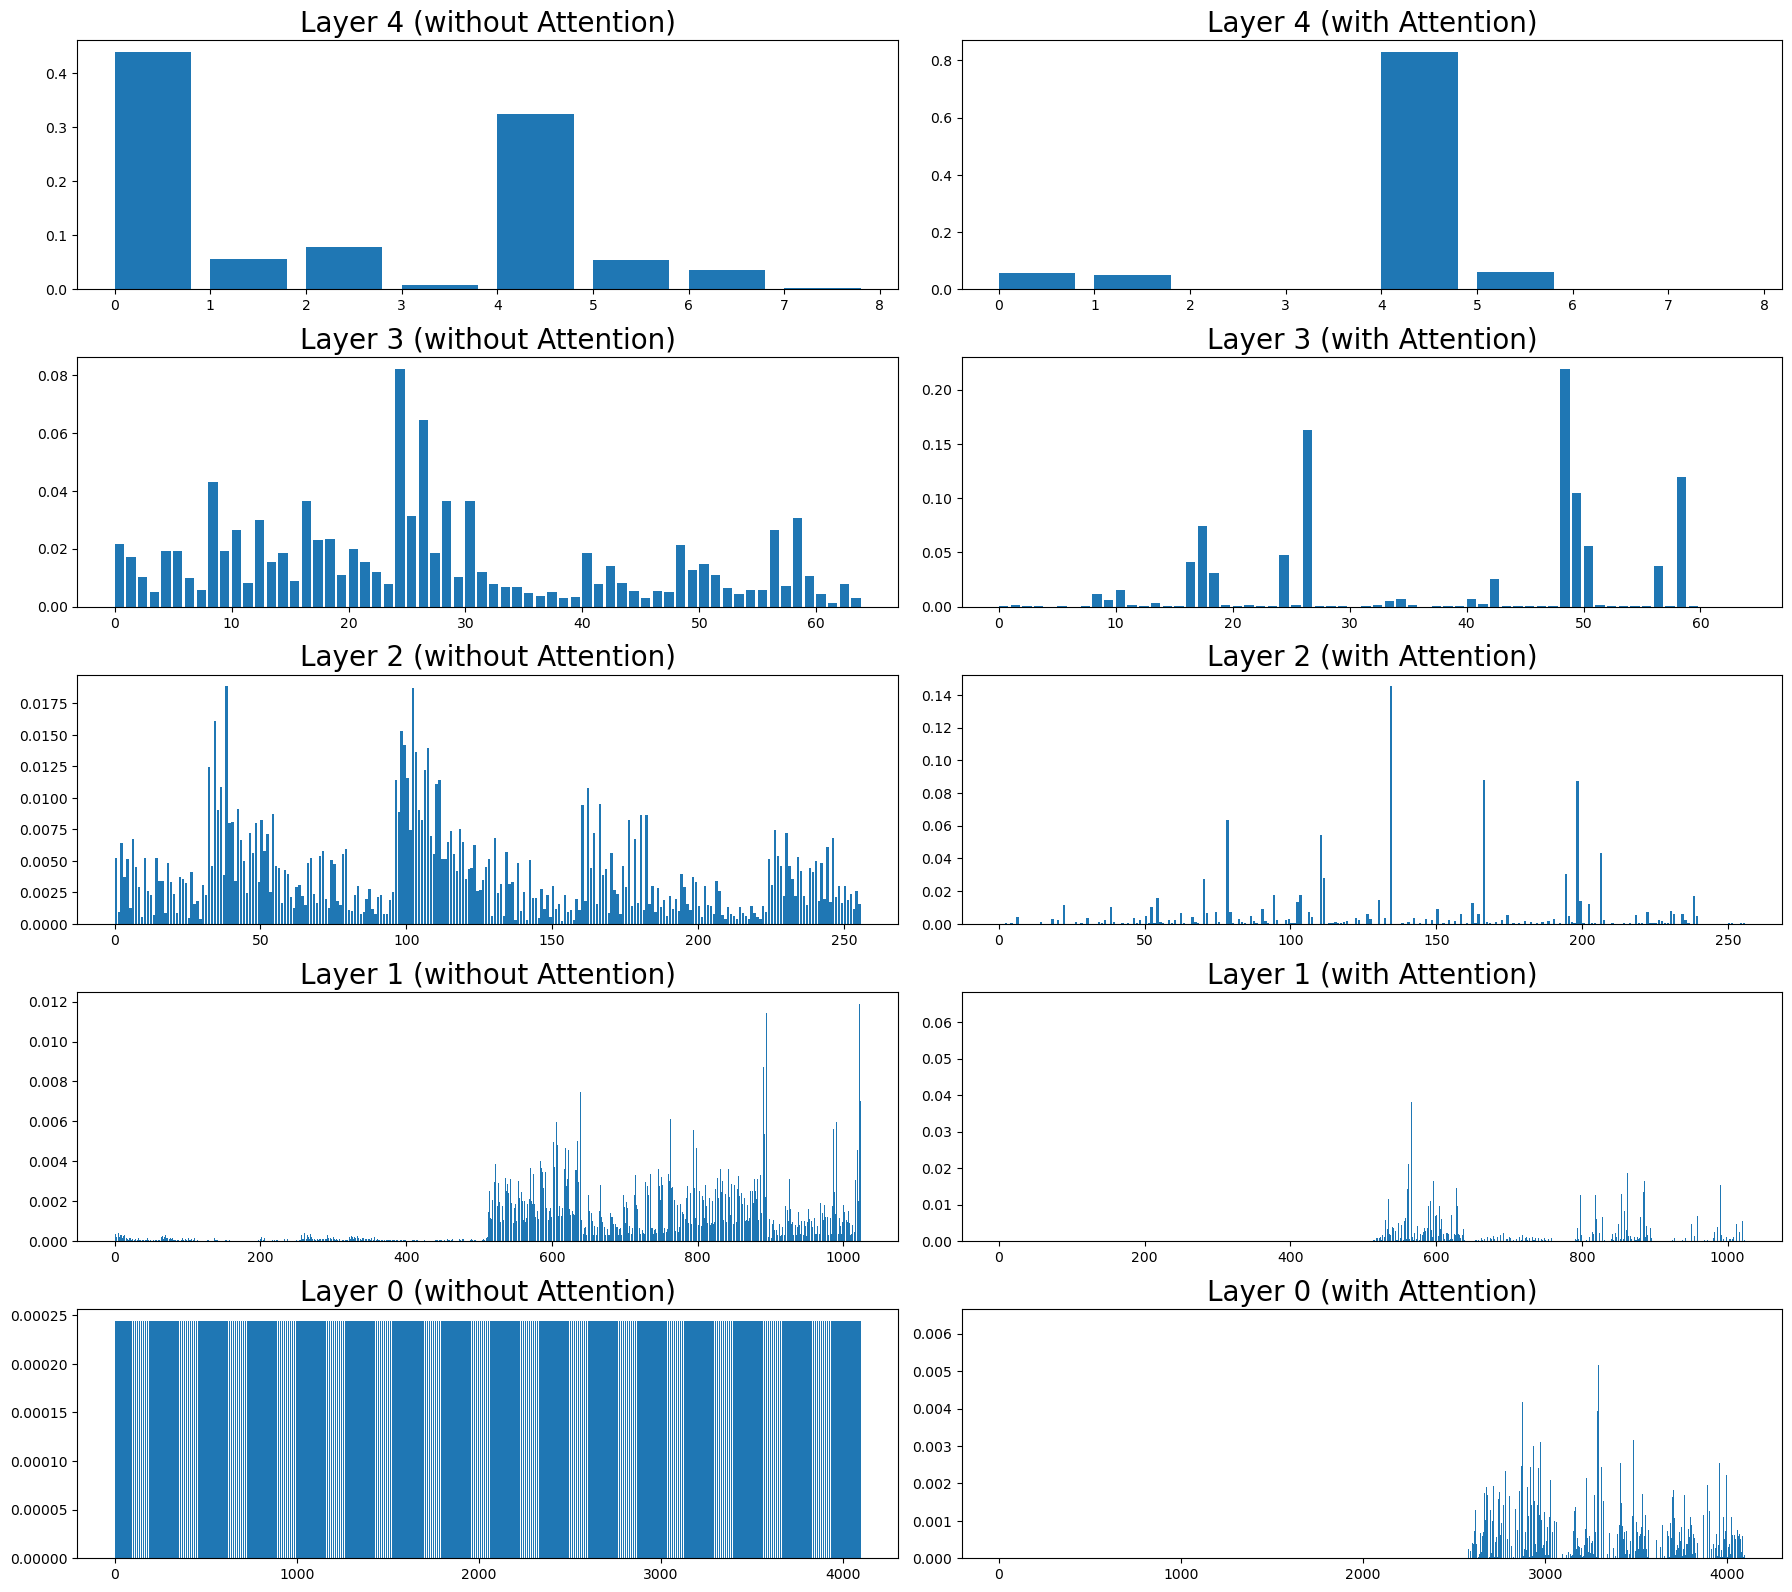

In [240]:
cause_dist, cause_dist_pp = wake_dist_pp(Phi, test_dist, n_dz, pp_dict, dev)
fig, ax = plt.subplots(n_layer-1, 2, figsize=(18, 16))
# fig.suptitle("Predictive Processing Cause Distribution",fontsize=25)
for i in range(n_layer-1):
    dist = cause_dist['Layer_'+str(i)]
    dist_pp = cause_dist_pp['Layer_'+str(i)]
    
    ax[n_layer-2-i,0].bar(np.arange(2**n_dz[i]),dist.to('cpu').numpy(),width=0.8,align='edge')
    ax[n_layer-2-i,1].bar(np.arange(2**n_dz[i]),dist_pp.to('cpu').numpy(),width=0.8,align='edge')
    ax[n_layer-2-i,0].set_title("Layer "+str(i)+' (without Attention)',fontsize=20)
    ax[n_layer-2-i,1].set_title("Layer "+str(i)+' (with Attention)',fontsize=20)

plt.tight_layout(pad=1)    
plt.show()

In [241]:
test_dist = torch.zeros(2**n_d,device=dev)
well_formed_dcm = decimalize(well_formed_set,dev)
test_dist[1] = 1

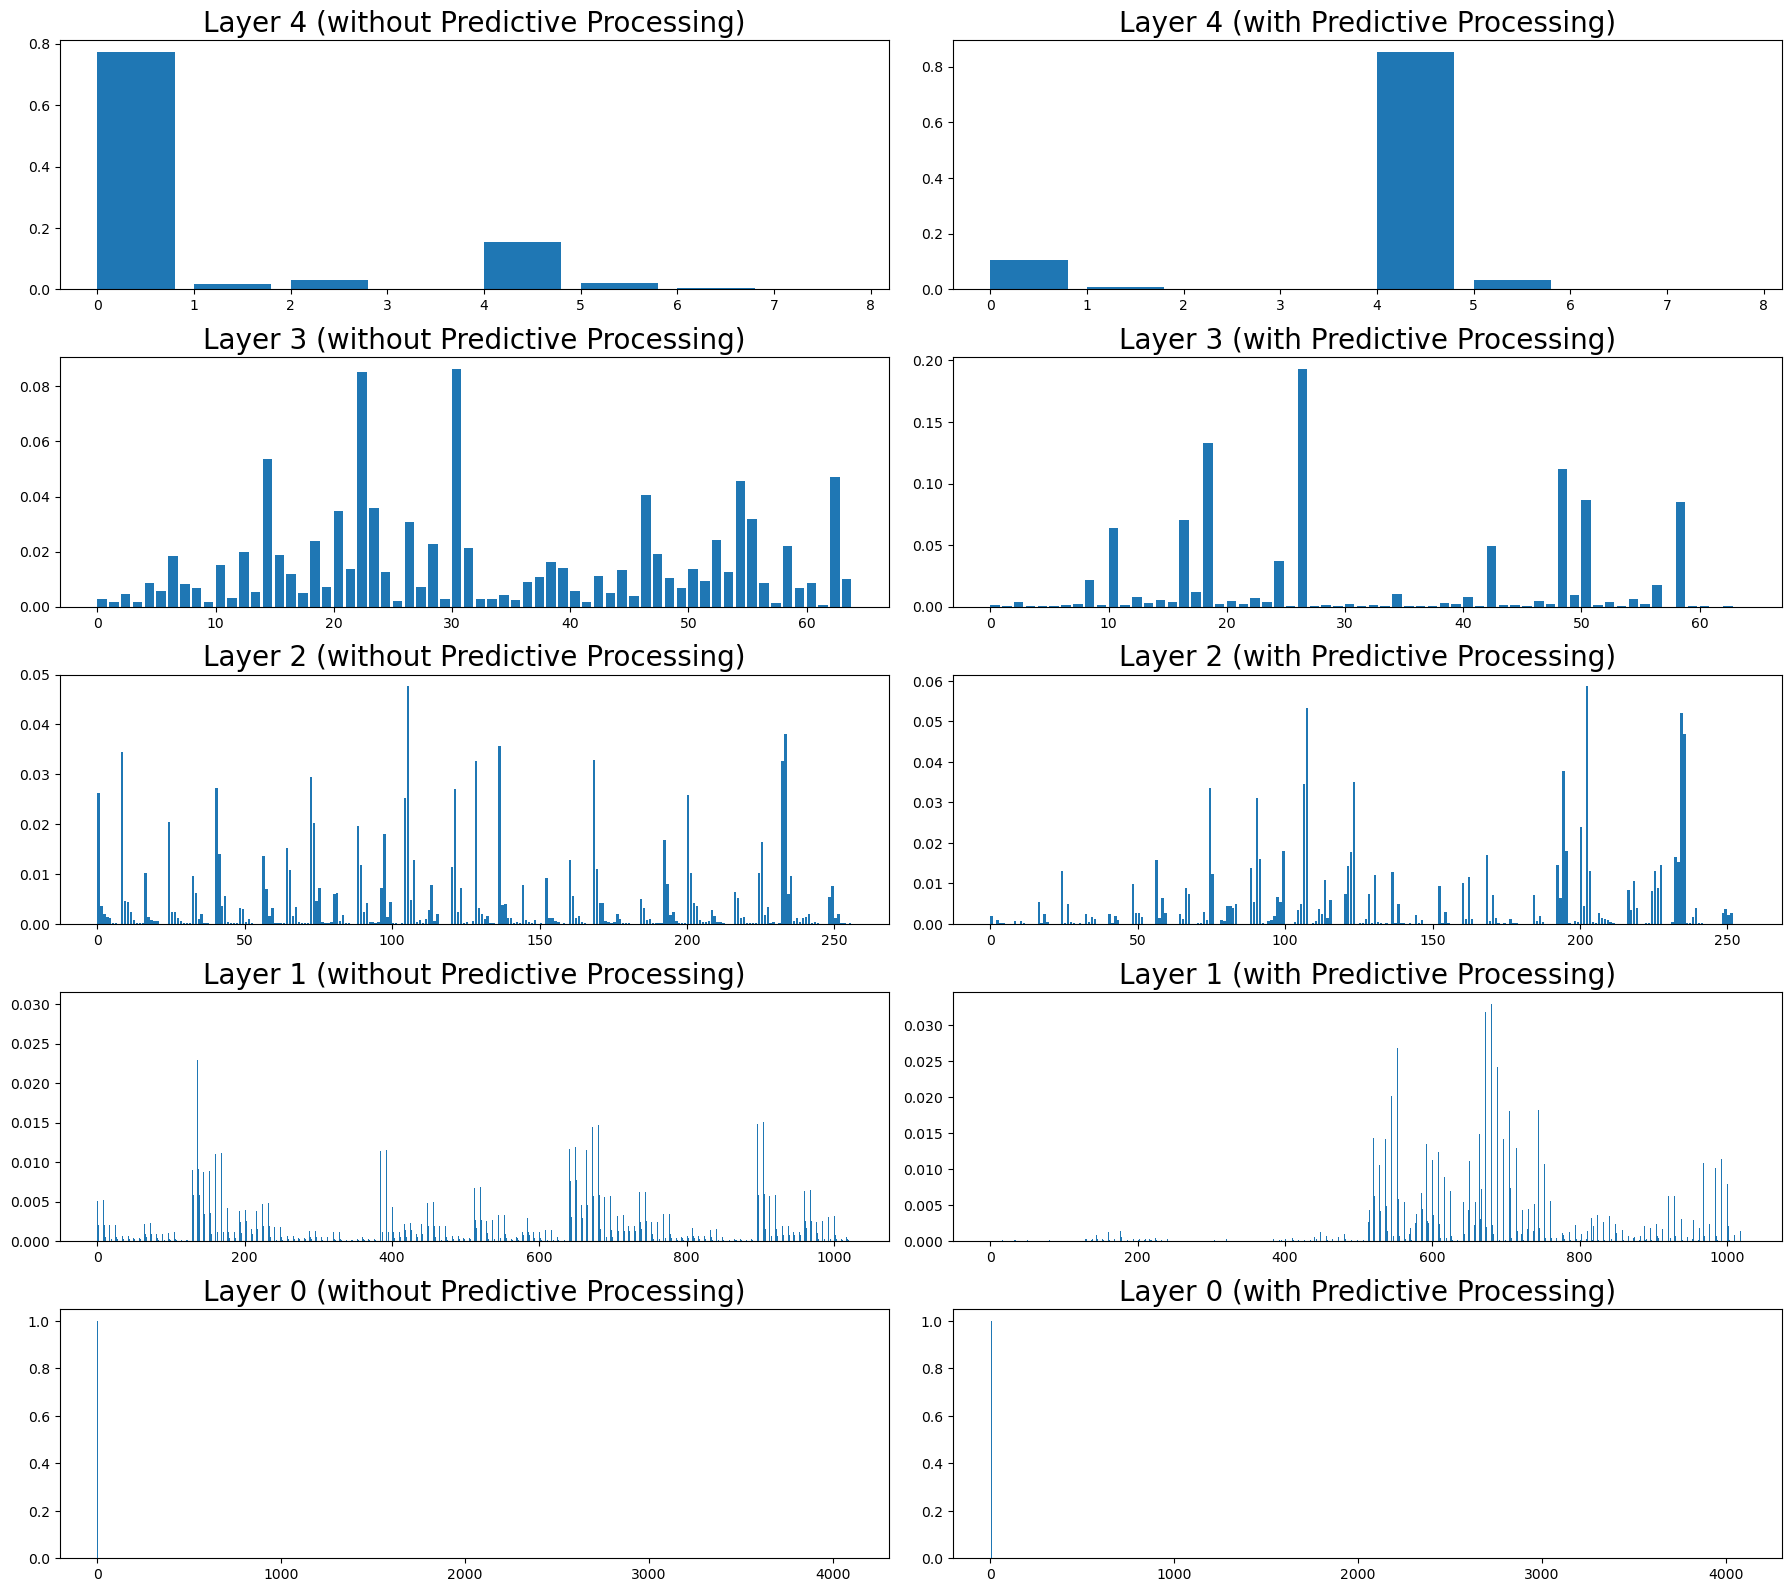

In [244]:
cause_dist, cause_dist_pp = wake_dist_pp(Phi, test_dist, n_dz, pp_dict, dev)
fig, ax = plt.subplots(n_layer-1, 2, figsize=(18, 16))
# fig.suptitle("Predictive Processing Cause Distribution",fontsize=25)
for i in range(n_layer-1):
    dist = cause_dist['Layer_'+str(i)]
    dist_pp = cause_dist_pp['Layer_'+str(i)]
    
    if i > 0:
        ax[n_layer-2-i,0].bar(np.arange(2**n_dz[i]),dist.to('cpu').numpy(),width=0.8,align='edge')
        ax[n_layer-2-i,1].bar(np.arange(2**n_dz[i]),dist_pp.to('cpu').numpy(),width=0.8,align='edge')
    else:
        ax[n_layer-2-i,0].bar(np.arange(2**n_dz[i]),dist.to('cpu').numpy(),width=5,align='edge')
        ax[n_layer-2-i,1].bar(np.arange(2**n_dz[i]),dist_pp.to('cpu').numpy(),width=7,align='edge')
    ax[n_layer-2-i,0].set_title("Layer "+str(i)+' (without Predictive Processing)',fontsize=20)
    ax[n_layer-2-i,1].set_title("Layer "+str(i)+' (with Predictive Processing)',fontsize=20)

plt.tight_layout(pad=1)    
plt.show()

### Plot Analytic

In [109]:
# Analytic_ws_online['Index'] = Analytic_ws_online.index

In [110]:
# for i in range(len(col_list)):
#     Analytic_ws_online.plot(x='Index',y=col_list[i],kind='line',legend=True)
# plt.close()

In [155]:
x = np.arange(len(Analytic_ws_online_MI))

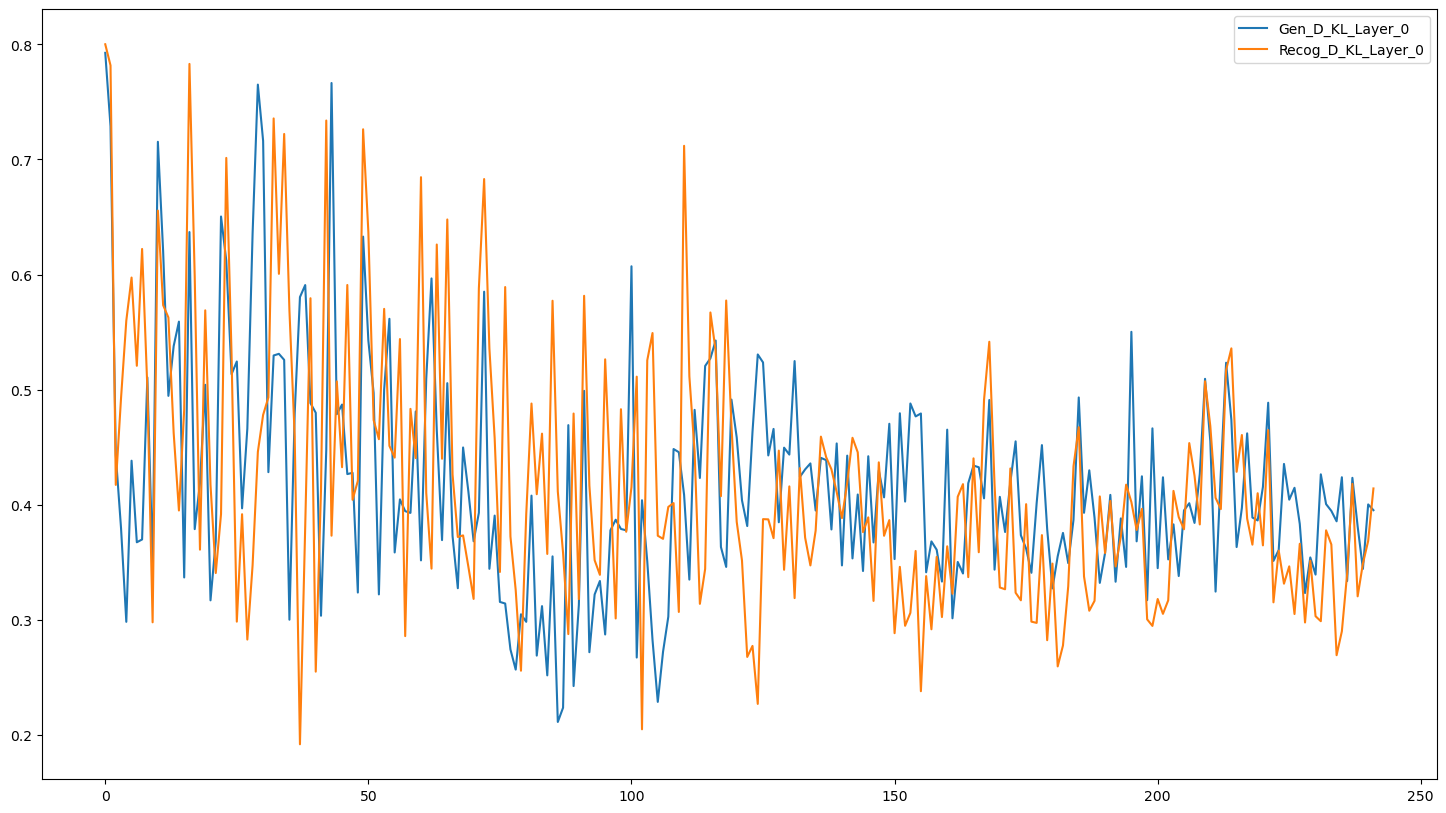

In [156]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(x, np.array(Analytic_ws_online_MI['Gen_D_KL_Layer_'+str(0)]),label = 'Gen_D_KL_Layer_'+str(0))
ax.plot(x, np.array(Analytic_ws_online_MI['Recog_D_KL_Layer_'+str(0)])/np.array(Analytic_ws_online_MI['Recog_D_KL_Layer_'+str(0)]).mean()*np.array(Analytic_ws_online_MI['Gen_D_KL_Layer_'+str(0)]).mean(),label = 'Recog_D_KL_Layer_'+str(0))
# ax.plot(x, np.array(Analytic_ws_online_MI['Recog_D_KL_Layer_'+str(0)]),label = 'Recog_D_KL_Layer_'+str(0))
ax.legend()
plt.show()

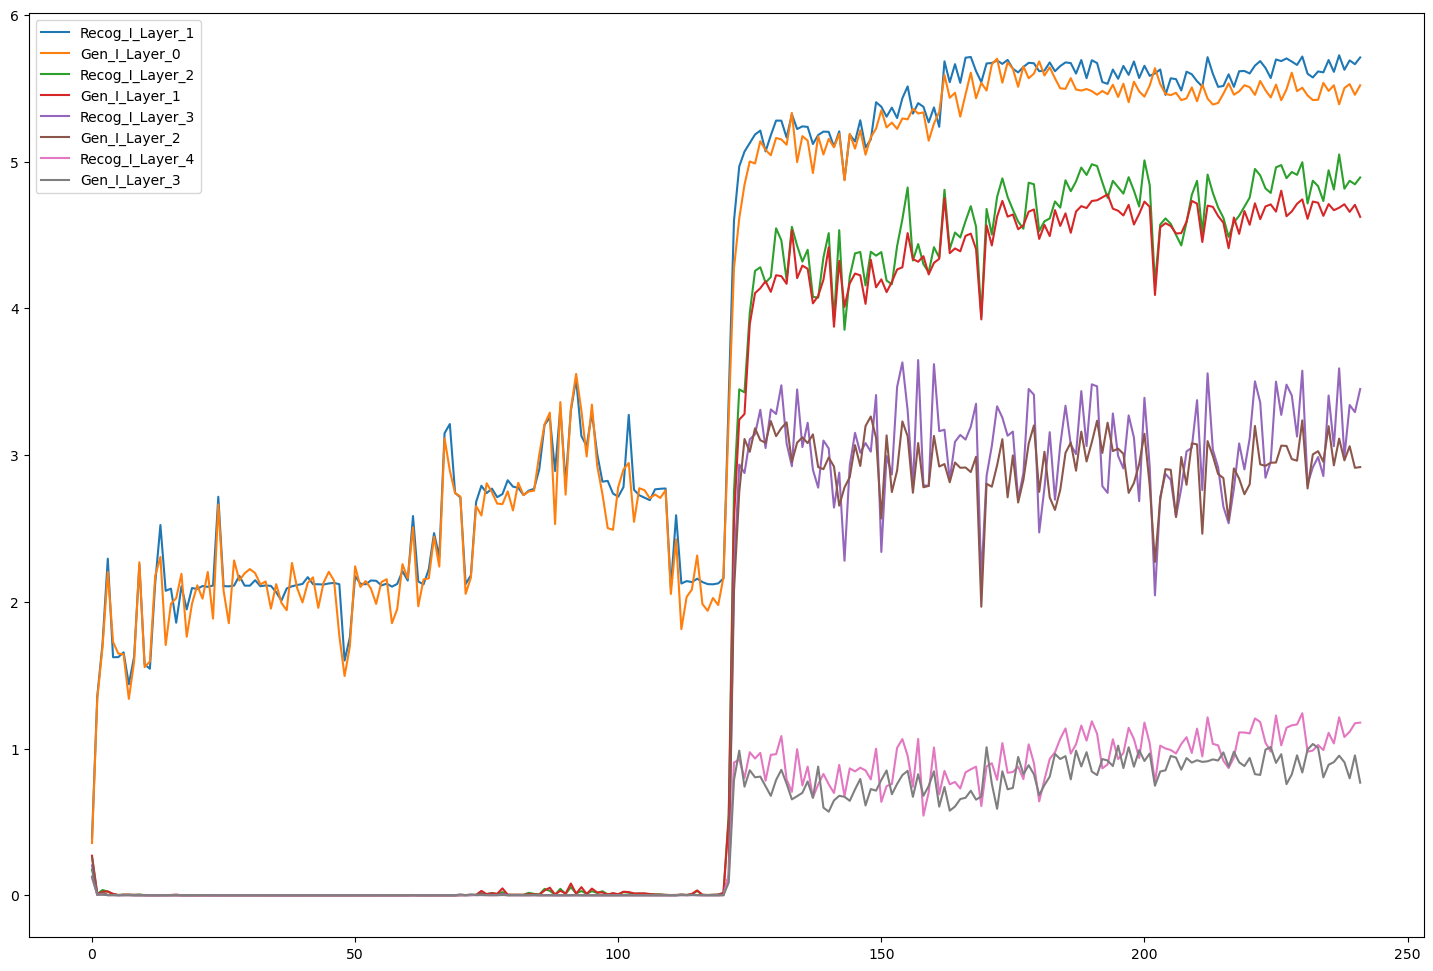

In [157]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(n_layer-2):
    ax.plot(x, np.array(Analytic_ws_online_MI['Recog_I_Layer_'+str(i+1)]),label = 'Recog_I_Layer_'+str(i+1))
    ax.plot(x, np.array(Analytic_ws_online_MI['Gen_I_Layer_'+str(i)]),label = 'Gen_I_Layer_'+str(i))
ax.legend()
plt.show()

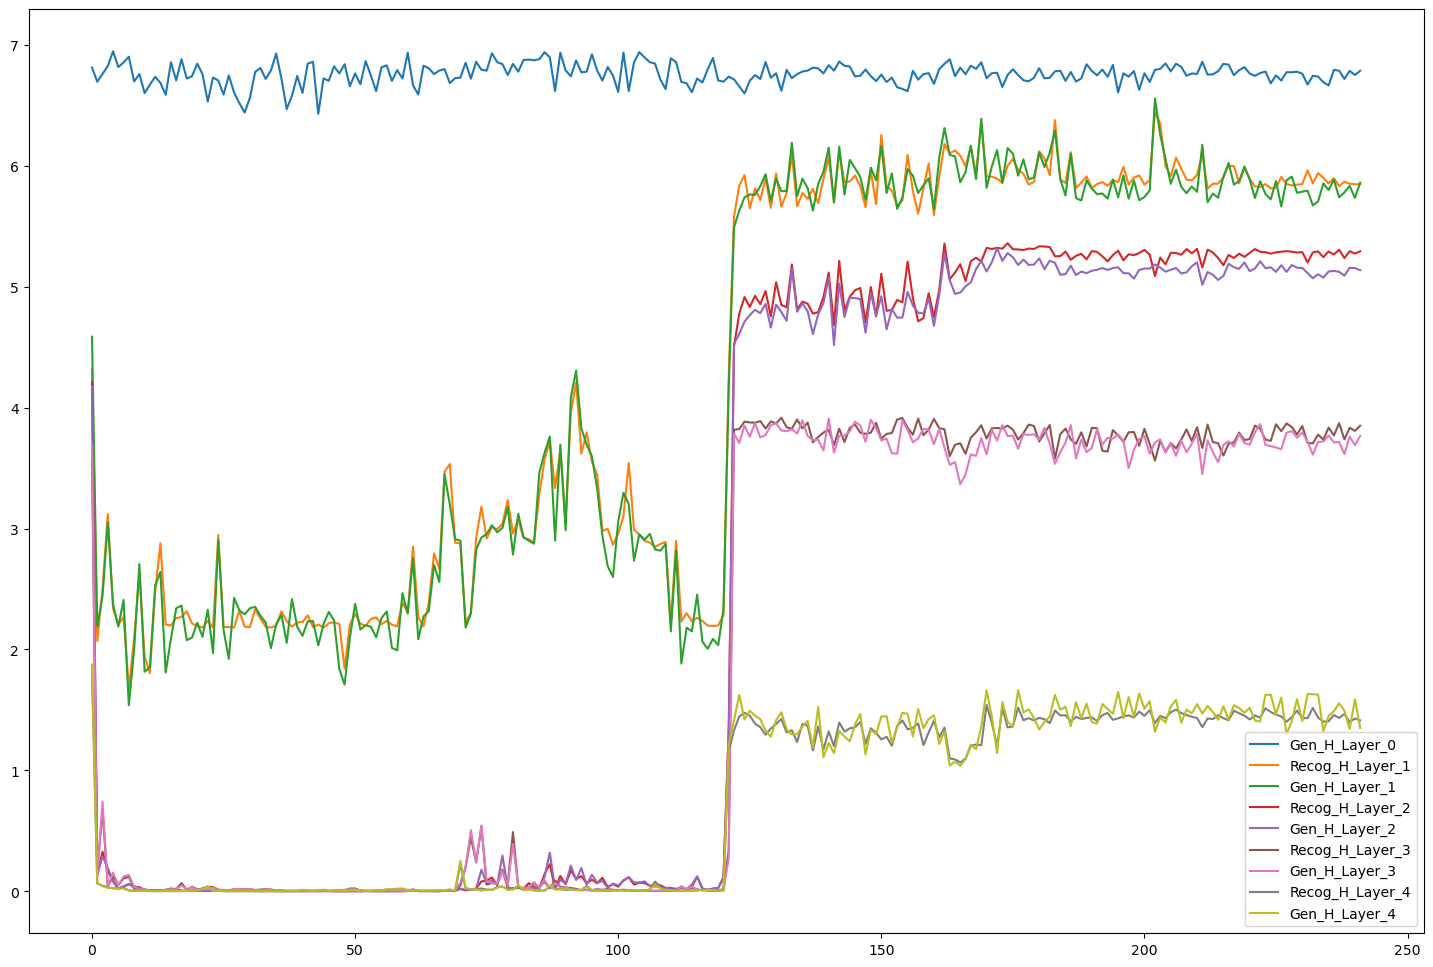

In [158]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(x, np.array(Analytic_ws_online_MI['Gen_H_Layer_'+str(0)]),label = 'Gen_H_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(x, np.array(Analytic_ws_online_MI['Recog_H_Layer_'+str(i)]),label = 'Recog_H_Layer_'+str(i))
    ax.plot(x, np.array(Analytic_ws_online_MI['Gen_H_Layer_'+str(i)]),label = 'Gen_H_Layer_'+str(i))
ax.legend()
plt.show()

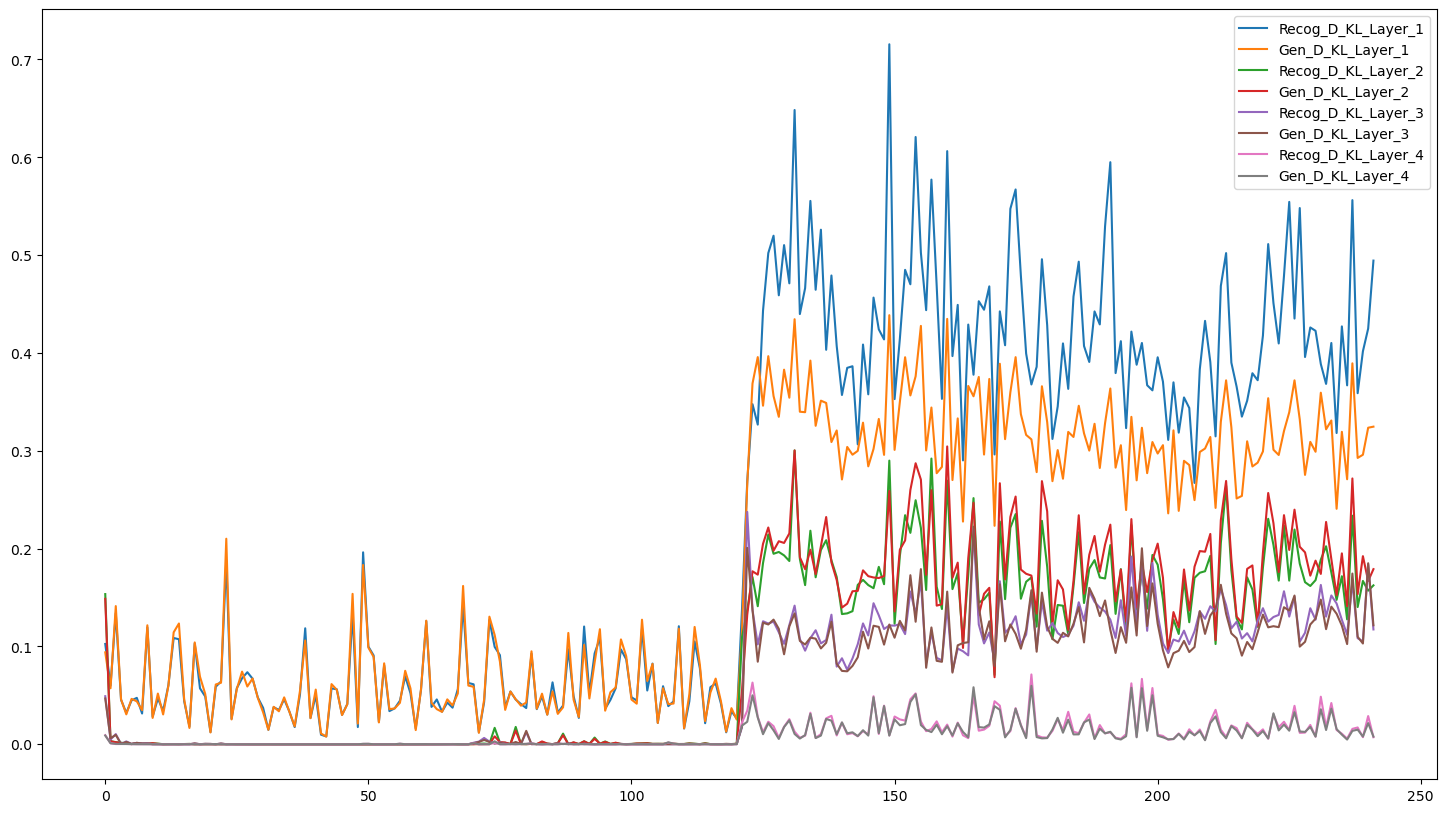

In [159]:
fig, ax = plt.subplots(figsize=(18, 10))
for i in range(1,n_layer-1):
    ax.plot(x, np.array(Analytic_ws_online_MI['Recog_D_KL_Layer_'+str(i)]),label = 'Recog_D_KL_Layer_'+str(i))
    ax.plot(x, np.array(Analytic_ws_online_MI['Gen_D_KL_Layer_'+str(i)]),label = 'Gen_D_KL_Layer_'+str(i))
ax.legend()
plt.show()

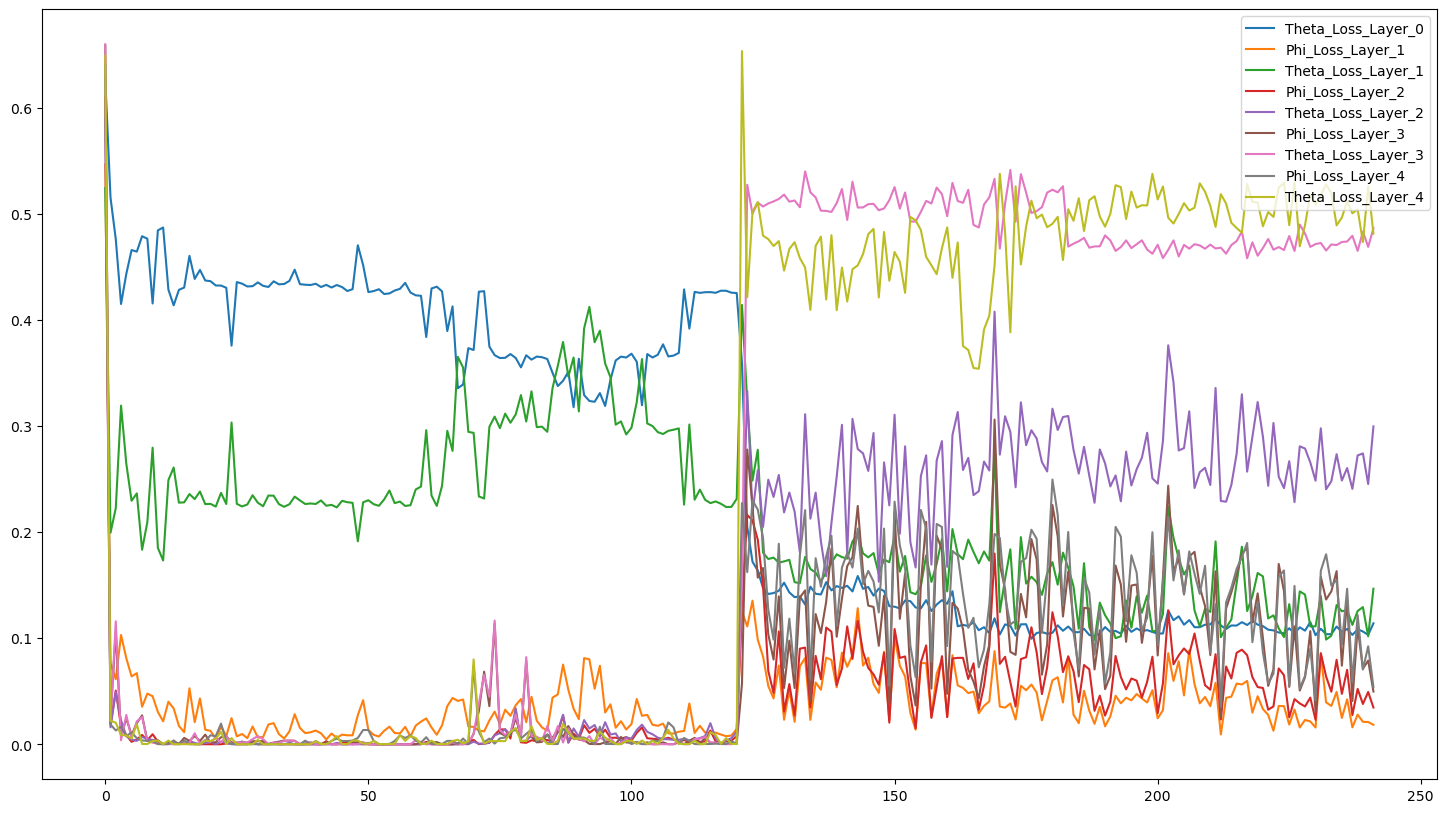

In [160]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(x, np.array(Analytic_ws_online_MI['Theta_Loss_Layer_'+str(0)]),label = 'Theta_Loss_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(x, np.array(Analytic_ws_online_MI['Phi_Loss_Layer_'+str(i)]),label = 'Phi_Loss_Layer_'+str(i))
    ax.plot(x, np.array(Analytic_ws_online_MI['Theta_Loss_Layer_'+str(i)]),label = 'Theta_Loss_Layer_'+str(i))
ax.legend()
plt.show()